# Empirical Data Analysis

We introduce a novel technique to extrapolate/predict the expected number of coverage elements to discover in a fuzzing campaign, if we continue the campaign a bit further.

* **Experiments -** We ran the state-of-the-art greybox fuzzer, AFL++ on multiple subject programs with various number of LoC.

* **Analysis -** In this notebook, we present our novel algorithm on obtained fuzzing data and evaluation of the results against the existing extrapolation technique.


In [1]:
#Required libraries
library(rjson)
library(stringr)
library(jsonlite)
library(ggplot2)
library(dplyr)
library(tidyverse)
library(scales)
library(grid)
library(gridExtra)
library(tidyr)
library(plotly)
library(foreach)
library(doParallel)
library(cowplot)
library(lsr)
library(rstatix)
library(colorspace)
library(viridis)
library(reshape2)
library(ggpubr)

REGENERATE_DATA = FALSE

options(warn=-1) # Supress irrelevant warnings


Attaching package: 'jsonlite'


The following objects are masked from 'package:rjson':

    fromJSON, toJSON



Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


-- Attaching core tidyverse packages ------------------------ tidyverse 2.0.0 --
v forcats   1.0.0     v readr     2.1.4
v lubridate 1.9.2     v tibble    3.2.1
v purrr     1.0.1     v tidyr     1.3.0
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter()      masks stats::filter()
x purrr::flatten()     masks jsonlite::flatten()
x jsonlite::fromJSON() masks rjson::fromJSON()
x dplyr::lag()         masks stats::lag()
x jsonlite::toJSON()   masks rjson::toJSON()
i Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: 'scales'


The following object is masked from 'package

## Extrapolate coverage for real-world programs

In [2]:
alp = 0.3 # Alpha parameter
if(REGENERATE_DATA){
    
    unzip("data/fuzztastic_data.zip",exdir="data/")
    
    subjects = list.files("data/fuzztastic_data/")
    
    RESET = TRUE
    sub1 = 1
    sub2 = 1
    n_reps = 5
    for(subject in subjects){
        folder = paste("data/fuzztastic_data/",subject,"/","seed_01",sep="")
        for(file_run in list.files(folder)){
            data = tibble()
            subject = subject
            run = str_sub(file_run,-2)
            timestamps = c()
            n_list = c()
            sn_list = c()
            f1_list = c()
            f2_list = c()
            u_list = c()
            for(file in list.files(paste(folder,"/",file_run,sep=""))){
                ## Prepare the hit count table using all the available data
                bb_cov = as.data.frame(fromJSON(paste(folder,"/",file_run,"/",file,sep="")))
                bb_cov = bb_cov %>% mutate(block_coverage = ifelse(block_coverage>=8,block_coverage-8,block_coverage)) # 8 calibration runs.
                temp = t(as.data.frame(bb_cov$block_coverage))
                colnames(temp) = 1:length(bb_cov$block_coverage)
                row.names(temp) = NULL
                temp = as.data.frame(temp)
                timestamps = c(timestamps,as.integer(substr(str_split(file,"_")[[1]][3],1,10)))
                n_list = c(n_list,max(bb_cov$block_coverage))
                sn_list = c(sn_list,sum((bb_cov$block_coverage)>0))
                data = rbind(data,temp)
            }
            bb_ids = 1:length(bb_cov$block_coverage)
            transformed = data %>% summarise(across(1:length(bb_ids),function(x) cumsum(c(0,ifelse(diff(x)>0,1,0)))))
            f1_list = apply(transformed,1,function(x) sum(as.numeric(unlist(x))==1))
            f2_list = apply(transformed,1,function(x) sum(as.numeric(unlist(x))==2))
            u_list = rowSums(transformed)
            gb_df = tibble(subject=subject,run=run,timestamp=timestamps,n=n_list,theta=0:length(n_list[-1]),
                           u=u_list,f1=f1_list,f2=f2_list,sn_gb=sn_list)
            ## Write gb_data
            if(sub1==1){
               write.table(gb_df, file = "data/gb_data.csv", row.names = FALSE,quote = FALSE)  
               sub1 = sub1 + 1
            }else{
               write.table(gb_df, file = "data/gb_data.csv",
                append = TRUE, quote = FALSE,
                col.names = FALSE, row.names = FALSE)
            }
            
            transformed = data %>% summarise(across(1:length(bb_ids),function(x) ifelse(diff(x)>0,1,0)))
            timestamps = timestamps[-1]
            n_list = n_list[-1]
            u_list = u_list[-1]
            sn_list = sn_list[-1]
            f1_list = f1_list[-1]
            f2_list = f2_list[-1]
            
            for(m in seq(1,length(u_list),4)){
                dis_prob = tibble()
                cores = detectCores()
                cl = makeCluster(cores[1]-1,type = "FORK")
                registerDoParallel(cl)
                ## Shuffling algorithm (difference, shuffle, reconstitute) for selected theta0
                ## Do the estimates for all X = theta0-k where 0<k<theta0 after the shuffling algorithm
                ## To get more estimates, repeat this several times (i.e. # of repetitions)
                dis_prob = foreach(rep=1:n_reps, .combine='rbind', .packages=c("dplyr", "tidyverse")) %dopar% {
                   filtered = transformed %>% mutate(theta=1:n()) %>% filter(theta<=m)
                   if(RESET){
                       cut_pt = round(exp(seq(log(1),log(m),length=11))[(10*(1-alp)+1)])
                       filtered = filtered %>% filter(theta>=cut_pt)
                   }else{
                       cut_pt = 0
                   }
                   theta_list = filtered$theta
                   filtered = filtered %>% select(-theta)
                   shuffle_order = sample(1:nrow(filtered),nrow(filtered))
                   filtered = filtered[shuffle_order,]
                   filtered = filtered %>% summarise(across(1:length(bb_ids),cumsum))
                   f1 = apply(filtered,1,function(x) sum(as.numeric(unlist(x))==1))
                   f2 = apply(filtered,1,function(x) sum(as.numeric(unlist(x))==2))
                   sn = apply(filtered,1,function(x) sum(as.numeric(unlist(x))>0))
                   rm(list = c("filtered"))
                   tibble(subject=subject,alpha=alp,run=run,repetition=rep,timestamp=timestamps[m],
                          time=timestamps[cut_pt:m],n0=n_list[m],n=n_list[cut_pt:m],theta=theta_list,
                          start=cut_pt,theta0=m,f1=f1+1,f2=f2+1,
                          gt = (f1/(theta-start))*(((theta-start-1)*f1)/((theta-start-1)*f1+(2*f2))),
                          sn=sn,s=length(bb_ids))
                }
                
                if(sub2==1){
                    write.table(dis_prob, file = "data/bb_data.csv", row.names = FALSE,quote = FALSE)
                    sub2 = sub2 + 1
                }else{
                    write.table(dis_prob, file = "data/bb_data.csv",
                    append = TRUE, quote = FALSE,
                    col.names = FALSE, row.names = FALSE)
                }
                stopCluster(cl)
                gc()
            }
        }
    }
    ## Save gathered data as R objects for future use
    gb_data = read.table("data/gb_data.csv",header=T)
    gb_data$run = as.factor(gb_data$run)
    
    gb_data = gb_data %>%
                rename(f1_gb=f1,f2_gb=f2) %>% 
                mutate(f1_gb = f1_gb + 1, f2_gb = f2_gb + 1)
    save(gb_data,file="data/gb_data.Rdata")
    
    bb_data = read.table("data/bb_data.csv",header=T)
    # Remove infinite values from extrapolated data table
    bb_data = bb_data %>% filter_all(all_vars(!is.infinite(.)))
    bb_data$run = as.factor(bb_data$run)
    
    # Attach greybox data to shuffling data
    bb_data = merge(bb_data,gb_data %>% select(subject,run,timestamp,f1_gb,f2_gb,sn_gb),
                    by=c("subject","run","timestamp"),all.x = TRUE)
    bb_data = bb_data %>% filter(gt > 0)
    
    # Since bb_data is a very large table, we slipt it to 3 smaller data frames and save
    bb_data_1 = bb_data %>% filter(subject %in% unique(gb_data$subject)[1:2])
    save(bb_data_1,file="data/bb_data_1.Rdata")
    bb_data_2 = bb_data %>% filter(subject %in% unique(gb_data$subject)[3:4])
    save(bb_data_2,file="data/bb_data_2.Rdata")
    bb_data_3 = bb_data %>% filter(subject %in% unique(gb_data$subject)[5])
    save(bb_data_3,file="data/bb_data_3.Rdata")
    
    # Remove obsolete data frames
    rm(list = c("bb_data_1","bb_data_2","bb_data_3"))
} else{
    ## Loading saved data
    load(file="data/gb_data.Rdata")
    load(file="data/bb_data_1.Rdata")
    load(file="data/bb_data_2.Rdata")
    load(file="data/bb_data_3.Rdata")
    
    # Combine bb_data to a single data frame
    bb_data = rbind(bb_data_1,bb_data_2,bb_data_3)
    # Remove obsolete data frames
    rm(list = c("bb_data_1","bb_data_2","bb_data_3"))
    
}                       


### Perform extrapolation using novel and existing techniques

We perform linear extrapolation based on our proposed appeoach using the populated coverage rate estimates for historical data. Also we predict the coverage rates using existing technique as well.

In [3]:
## Perform Extrapolation
bet = 0.5 # beta parameter
if(REGENERATE_DATA){
    
    ## Existing extrapolator
    hat_snm = function(f1,f2,theta,m){
        f0_hat = ifelse(f2!=0,((theta-1)/(theta))*((f1^2)/(2*f2)),((theta-1)/(theta))*((f1*(f1-1))/(2)))
        est = f0_hat*(1-((1-(f1/(theta*f0_hat+f1)))^m)) - f0_hat*(1-((1-(f1/(theta*f0_hat+f1)))^(m-1)))
        est = ifelse(is.nan(est),0,est)
        return(est)
    }

    ########################################
    # Filter a random run
    init = 1
    train_data = tibble()
    t0_list = seq(50,max(gb_data$theta),by=50)
    subjects = unique(gb_data$subject)
    proportions = c(0.5,0.75,1,1.5,2,3)
    for(sub in subjects){
        for(trial in unique(bb_data$run)){
            # Filter required data
            bb_df = bb_data %>% filter(run==trial) %>% filter(subject==sub) %>% filter(theta>=round(theta0*(1-bet)))
            gb_df = gb_data %>% filter(run==trial) %>% filter(subject==sub)
            for(t0 in t0_list){
                
                ######################################
                reg_df = bb_df %>% filter(theta0<=t0)
                
                tryCatch({
                # Only to get most recent points as training
                train_limit = exp(seq(log(min((reg_df %>% filter(theta>0))$theta)),
                                      log(max((reg_df %>% filter(theta>0))$theta0)),length=11))[(10*(1-gam)+1)]
                reg_df = reg_df %>% arrange(theta) %>% filter(theta>=train_limit)
        
                reg_df[is.na(reg_df) | reg_df == "Inf"] = NA
                #reg_df = reg_df %>% mutate(gt=replace(gt,gt==0,NA))
                reg_df = reg_df %>% drop_na()
                model = lm(log(gt)~log(theta),data = reg_df)
                slope = model$coefficient[2]
                intercept = model$coefficient[1]
                
                ######################################
                predict_df = (gb_df %>% arrange(theta) %>% filter(theta>=max(reg_df$theta)))
                #predict_df = predict_df %>% mutate(gt_gb=f1_gb/theta)
                f1_gb = predict_df$f1_gb[1]
                f2_gb = predict_df$f2_gb[1]
                theta0 = predict_df$theta[1]
                #u0 = predict_df$u[1]
                extra_df = tibble()
                for(prop in proportions){
                    m = round(prop*t0)
                    if(nrow(predict_df)<m){
                    m = nrow(predict_df)
                    }
                    delta_existing=as.numeric(lapply(1:m, function(x) hat_snm(f1_gb,f2_gb,theta0,x)))
                    delta_new=as.numeric(lapply(1:m, function(x) exp((slope*log(theta0+x)+intercept))))
                                                
                    extra_df = rbind(extra_df,
                                     tibble(subject=sub,alpha=alp,beta=bet,gamma=gam,run=trial,theta0=t0,prop=prop,
                                            theta=seq(max(reg_df$theta),length=m),
                                            delta_existing=delta_existing,delta_new=delta_new,
                                            sn_gb=predict_df$sn_gb[1:m]))
                            
                }
                                         
                if(init==1){
                   write.table(extra_df, file = "data/extrapolated.csv", row.names = FALSE,quote = FALSE)
                   init = init + 1
                }else{
                   write.table(extra_df, file = "data/extrapolated.csv",
                   append = TRUE, quote = FALSE,
                   col.names = FALSE, row.names = FALSE)
                }
                                             
                train_data = rbind(train_data,reg_df)
                
                }, error=function(e){})
            }
        }
    }
    ## Save gathered data as R objects for future use
    extrapolated = read.table("data/extrapolated.csv",header=T)
    save(extrapolated,file="data/extrapolated.Rdata")

    save(train_data,file="data/train_data.Rdata")
    
    # Since train_data is a very large table, we slipt it to 6 smaller data frames and save them
    train_data_1 = train_data %>% filter(subject %in% subjects[1],run %in% c(1:15))
    save(train_data_1,file="data/train_data_1.Rdata")
    train_data_2 = train_data %>% filter(subject %in% subjects[1],run %in% c(16:30))
    save(train_data_2,file="data/train_data_2.Rdata")
    train_data_3 = train_data %>% filter(subject %in% subjects[2])
    save(train_data_3,file="data/train_data_3.Rdata")
    train_data_4 = train_data %>% filter(subject %in% subjects[3])
    save(train_data_4,file="data/train_data_4.Rdata")
    train_data_5 = train_data %>% filter(subject %in% subjects[4])
    save(train_data_5,file="data/train_data_5.Rdata")
    train_data_6 = train_data %>% filter(subject %in% subjects[5])
    save(train_data_6,file="data/train_data_6.Rdata")
    
    # Remove obsolete data frames
    rm(list = c("train_data_1","train_data_2","train_data_3","train_data_4","train_data_5","train_data_6"))
}else{
    ## Loading saved data
    load(file="data/extrapolated.Rdata")
    load(file="data/train_data_1.Rdata")
    load(file="data/train_data_2.Rdata")
    load(file="data/train_data_3.Rdata")
    load(file="data/train_data_4.Rdata")
    load(file="data/train_data_5.Rdata")
    load(file="data/train_data_6.Rdata")
    
    # Combine bb_data to a single data frame
    train_data = rbind(train_data_1,train_data_2,train_data_3,train_data_4,train_data_5,train_data_6)
    # Remove obsolete data frames
    rm(list = c("train_data_1","train_data_2","train_data_3","train_data_4","train_data_5","train_data_6"))
}


### Data cleaning

In [4]:
# Filter out outlying runs
exclude_runs = unique((gb_data %>% filter(subject=="jasper" & sn_gb>5000))$run)
gb_data = gb_data %>% filter(!(subject=="jasper" & run %in% exclude_runs))
bb_data = bb_data %>% filter(!(subject=="jasper" & run %in% exclude_runs))
extrapolated = extrapolated %>% filter(!(subject=="jasper" & run %in% exclude_runs))
#train_data = train_data %>% filter(!(subject=="jasper" & run %in% exclude_runs))

In [5]:
# Smoothing singleton (f1) and doubleton (f1) counts to make existing extrapolation possible
smooth_bb_df = bb_data %>%
                group_by(subject,run,theta) %>%
                summarise_at(vars(-c(repetition,theta0)),mean,na.rm=TRUE) %>%
                mutate(smooth_f1_gb=predict(loess(f1_gb ~ theta, span=0.2)),
                       smooth_f2_gb=predict(loess(f1_gb ~ theta, span=0.2)),
                       smooth_f1_gb=ifelse(smooth_f1_gb<0,0,smooth_f1_gb),
                       smooth_f2_gb=ifelse(smooth_f2_gb<0,0,smooth_f2_gb)) %>%
                select(subject,run,theta,smooth_f1_gb,smooth_f2_gb) %>%
                rename(theta0=theta)

extrapolated = merge(extrapolated,smooth_bb_df,by=c("subject","run","theta0"),all.x=TRUE)

## Existing extrapolator
hat_snm = function(f1,f2,theta,m){
    f0_hat = ifelse(f2!=0,((theta-1)/(theta))*((f1^2)/(2*f2)),((theta-1)/(theta))*((f1*(f1-1))/(2)))
    est = f0_hat*(1-((1-(f1/(theta*f0_hat+f1)))^m)) - f0_hat*(1-((1-(f1/(theta*f0_hat+f1)))^(m-1)))
    est = ifelse(is.nan(est),0,est)
    return(est)
}

# Recompute existing extrapolation using smooth data
extrapolated = extrapolated %>%
            mutate(delta_existing=as.numeric(hat_snm(smooth_f1_gb,smooth_f2_gb,theta0,(theta-theta0))))

head(extrapolated)

subject   run theta0 prop theta delta_existing delta_new sn_gb smooth_f1_gb
1 freetype2 1   50     2     89   0.98406800     8.303428  6243  234.1989    
2 freetype2 1   50     2     91   0.90839956     8.059109  6282  234.1989    
3 freetype2 1   50     2     88   1.02423404     8.430457  6243  234.1989    
4 freetype2 1   50     2     92   0.87277605     7.941586  6283  234.1989    
5 freetype2 1   50     3    113   0.37674440     6.022236  6348  234.1989    
6 freetype2 1   50     3    154   0.07306491     3.966931  6500  234.1989    
  smooth_f2_gb
1 234.1989    
2 234.1989    
3 234.1989    
4 234.1989    
5 234.1989    
6 234.1989

### Compute ground-truth

`summarise()` has grouped output by 'subject', 'run'. You can override using
the `.groups` argument.


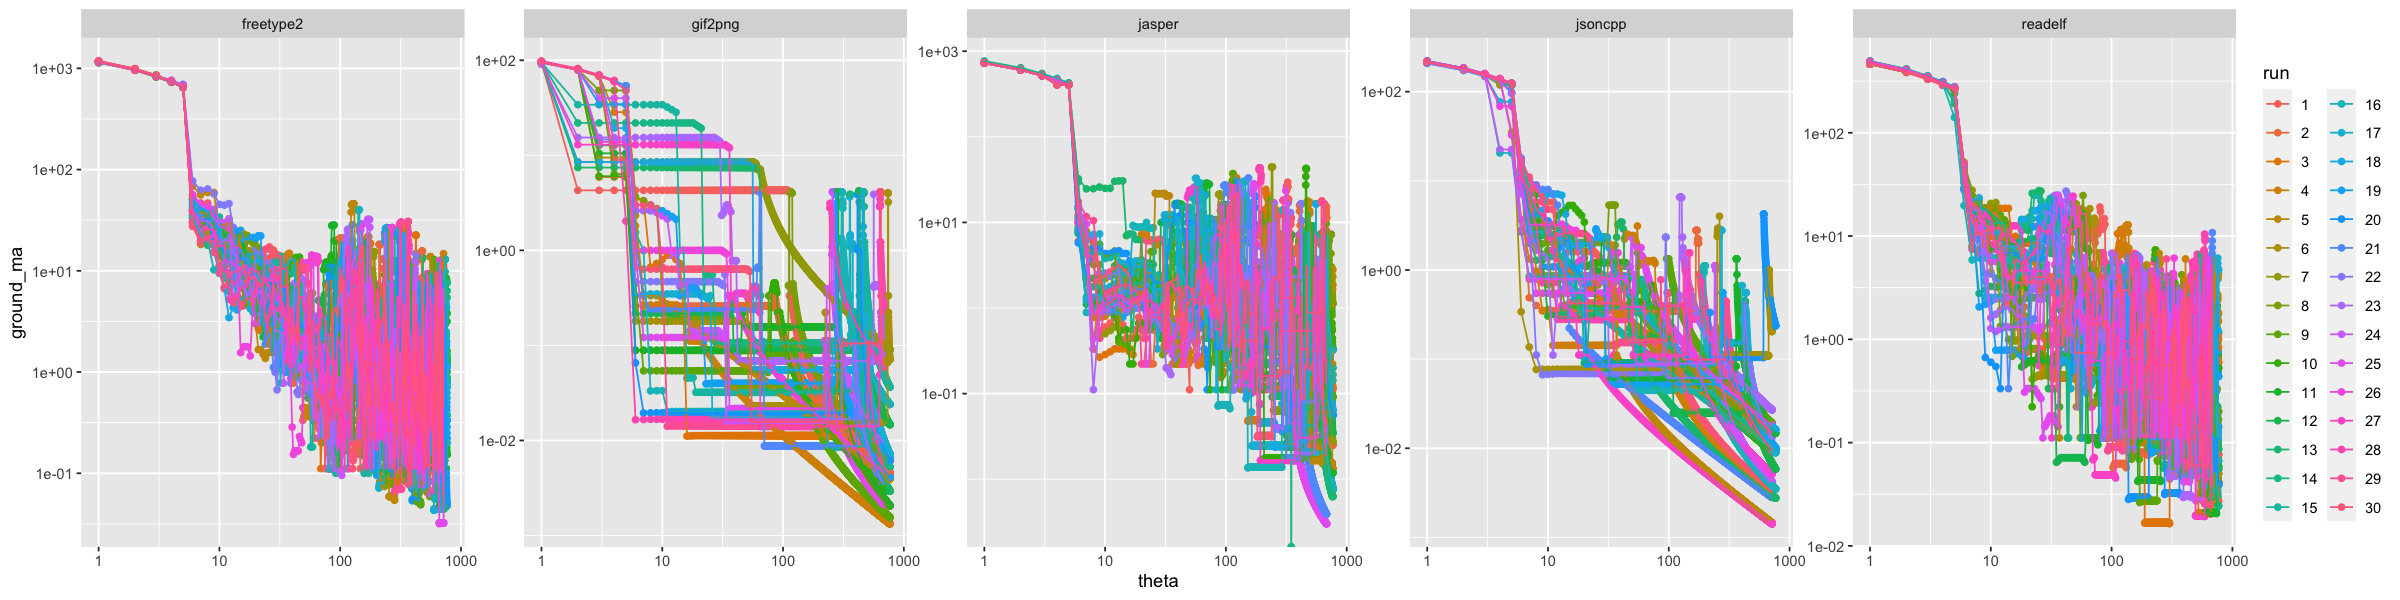

In [6]:
# Function to smooth the empirical coverage rates to obtain ground truth
moving_average = function(x, n = 5) {
    ret = c()
    for (i in 1:length(x)) {
        min_idx = max(1, i - n + 1)
        max_idx = min(length(x), i + n - 1)
        if (sum(x[min_idx:i]) == 0) {
            # find closest non-zero value
            if (min_idx - 1 >= 1) {
                for (j in seq(min_idx - 1, 1, -1)) {
                    if (x[j] > 0) {
                        min_idx = j
                        break
                    }
                }
            }
        }
        if (sum(x[i:max_idx]) == 0) {
            # find closest non-zero value
            if (max_idx + 1 <= length(x)) {
                for (j in seq(max_idx + 1, length(x))) {
                    if (x[j] > 0) {
                        max_idx = j
                        break
                    }
                }
            }
        }
        ret = c(ret, mean(x[min_idx:max_idx]))
    }
    return (ret)
}

# Compute the ground-truth using smoothen species richness curve
gt_data = gb_data %>%
              group_by(subject,run) %>%
              mutate(smooth_gb = sn_gb) %>%
              ungroup()%>%
              group_by(subject,run,theta) %>%
              summarise(mean_sn=mean(smooth_gb),) %>%
              arrange(theta) %>%
              mutate(ground = c(NA, diff(mean_sn))) %>%
              mutate(ground_ma=c(NA,moving_average(diff(mean_sn)))) %>%
              ungroup()

# Plot ground truth
options(repr.plot.width = 20, repr.plot.height = 5)
gt_data %>%
ggplot() +
geom_point(aes(theta,ground_ma,color=run)) + 
geom_line(aes(theta,ground_ma,color=run)) +
scale_x_log10() +
scale_y_log10() +
facet_wrap(~subject,ncol=5,scales="free")

### Showcase extrapolation performance

A comparison between the mean squared error (MSE) of our extrapolator and existing extrapolator. We make predictions at verious points *theta0* for different horizons *m*.

In [7]:
## Showcase an extrapolation scenario for a given subject
selected_sub = "freetype2"
selected_t0 = 150
                            
train_df = train_data %>% filter(subject==selected_sub) %>% filter(theta0<=selected_t0) %>% 
                    mutate(train_limit=exp(seq(log(min(theta)),
                                      log(max(theta0)),length=11))[(10*(1-bet)+1)]) %>% 
                    filter(theta>=train_limit) %>% 
                    group_by(run) %>% 
                    mutate(keep=ifelse((selected_t0-max(theta))>5,0,1)) %>%
                    filter(keep==1)

extra_df = extrapolated %>% filter(subject==selected_sub) %>% 
                    filter(theta0<=selected_t0) %>% filter(theta0==max(theta0)) %>% 
                    filter(prop==3) %>% 
                    filter(run %in% unique(train_df$run))

bb_df = bb_data %>% filter(subject==selected_sub) %>% filter(theta0<=selected_t0) %>%  
                    filter(run %in% unique(train_df$run))

gb_df = gb_data %>% filter(subject==selected_sub) %>% 
                    filter(run %in% unique(train_df$run))


`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


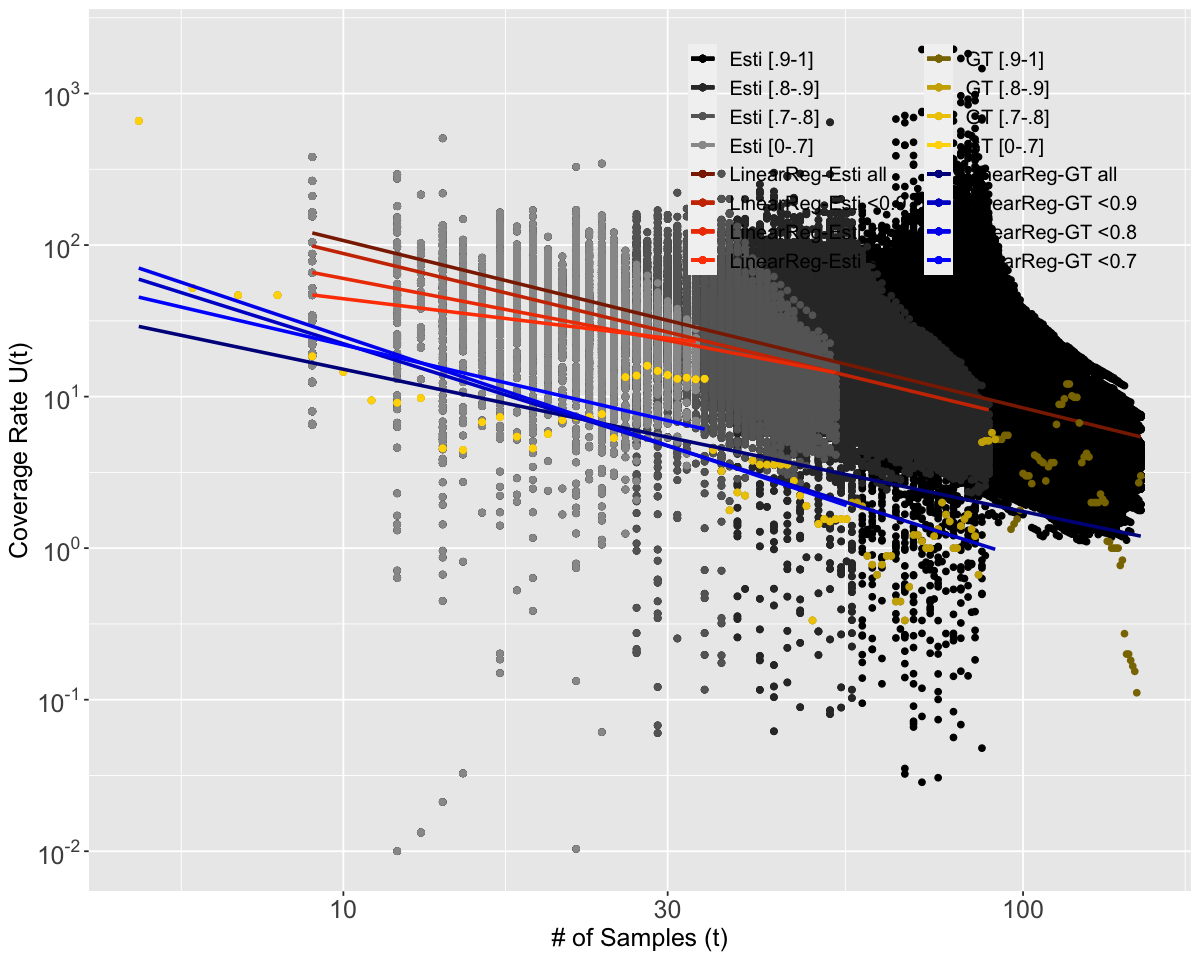

In [8]:
selected_run = 1
threshs = ceiling(exp((log(max(bb_df$theta)) / 10) * 1:10))

# Filter ground truth for the required trial
gt_df = gt_data %>%
    filter(subject == selected_sub) %>%
    filter(run == selected_run)

options(repr.plot.width = 10, repr.plot.height = 8)
plt = ggplot() +
    geom_point(data = bb_df, aes(theta, gt, color = "Esti [.9-1]")) +
    geom_point(data = (bb_df %>% filter(theta0 <= threshs[9])), aes(theta, gt, color = "Esti [.8-.9]")) +
    geom_point(data = (bb_df %>% filter(theta0 <= threshs[8])), aes(theta, gt, color = "Esti [.7-.8]")) +
    geom_point(data = (bb_df %>% filter(theta0 <= threshs[7])), aes(theta, gt, color = "Esti [0-.7]")) +
    geom_smooth(data = bb_df, aes(theta, gt, color = "LinearReg-Esti all"), method = "lm", se = FALSE) +
    geom_smooth(data = (bb_df %>% filter(theta0 <= threshs[9])), aes(theta, gt, color = "LinearReg-Esti <0.9"), 
                method = "lm", se = FALSE) +
    geom_smooth(data = (bb_df %>% filter(theta0 <= threshs[8])), aes(theta, gt, color = "LinearReg-Esti <0.8"), 
                method = "lm", se = FALSE) +
    geom_smooth(data = (bb_df %>% filter(theta0 <= threshs[7])), aes(theta, gt, color = "LinearReg-Esti <0.7"), 
                method = "lm", se = FALSE) +
    geom_point(data = gt_df, aes(theta, ground_ma, color = "GT [.9-1]")) +
    geom_point(data = (gt_df %>% filter(theta <= threshs[9])), aes(theta, ground_ma, color = "GT [.8-.9]")) +
    geom_point(data = (gt_df %>% filter(theta <= threshs[8])), aes(theta, ground_ma, color = "GT [.7-.8]")) +
    geom_point(data = (gt_df %>% filter(theta <= threshs[7])), aes(theta, ground_ma, color = "GT [0-.7]")) +
    geom_smooth(data = gt_df, aes(theta, ground_ma, color = "LinearReg-GT all"), method = "lm", se = FALSE) +
    geom_smooth(data = (gt_df %>% filter(theta <= threshs[9])), aes(theta, ground_ma, color = "LinearReg-GT <0.9"), 
                method = "lm", se = FALSE) +
    geom_smooth(data = (gt_df %>% filter(theta <= threshs[8])), aes(theta, ground_ma, color = "LinearReg-GT <0.8"), 
                method = "lm", se = FALSE) +
    geom_smooth(data = (gt_df %>% filter(theta <= threshs[7])), aes(theta, ground_ma, color = "LinearReg-GT <0.7"), 
                method = "lm", se = FALSE) +
    scale_color_manual("",
        breaks = c(
            "Esti [.9-1]", "Esti [.8-.9]", "Esti [.7-.8]", "Esti [0-.7]", "LinearReg-Esti all", 
            "LinearReg-Esti <0.9", "LinearReg-Esti <0.8", "LinearReg-Esti <0.7",
            "GT [.9-1]", "GT [.8-.9]", "GT [.7-.8]", "GT [0-.7]", "LinearReg-GT all", "LinearReg-GT <0.9", 
            "LinearReg-GT <0.8", "LinearReg-GT <0.7"
        ),
        values = c(
            "black", "grey20", "grey40", "grey60", "orangered4", "orangered3", "orangered2", "orangered1",
            "gold4", "gold3", "gold2", "gold1", "blue4", "blue3", "blue2", "blue1"
        )
    ) +
    theme(
        axis.text.x = element_text(size = 15), axis.text.y = element_text(size = 15), 
        legend.text = element_text(size = 12),
        axis.title.y = element_text(size = 15), legend.title = element_text(size = 15),
        plot.caption = element_text(hjust = 0.5), axis.title.x = element_text(size = 15),
        strip.text.x = element_blank(), strip.text.y = element_text(size = 15)
    ) +
    scale_x_log10("# of Samples (t)", limit = c(5, max(bb_df$theta))) +
    scale_y_log10("Coverage Rate U(t)",
        breaks = trans_breaks("log10", function(x) 10^x),
        labels = trans_format("log10", math_format(10^.x))
    ) +
    # legend
    theme(legend.position = c(0.75, 0.85), legend.background = element_rect(fill = "transparent", color = NA)) +
    guides(color = guide_legend(ncol = 2))

g = grid.arrange(plt, nrow = 1)
ggsave(file="../figures/Figure-2.png",g,width = 10, height = 8, units = "in", device='png')

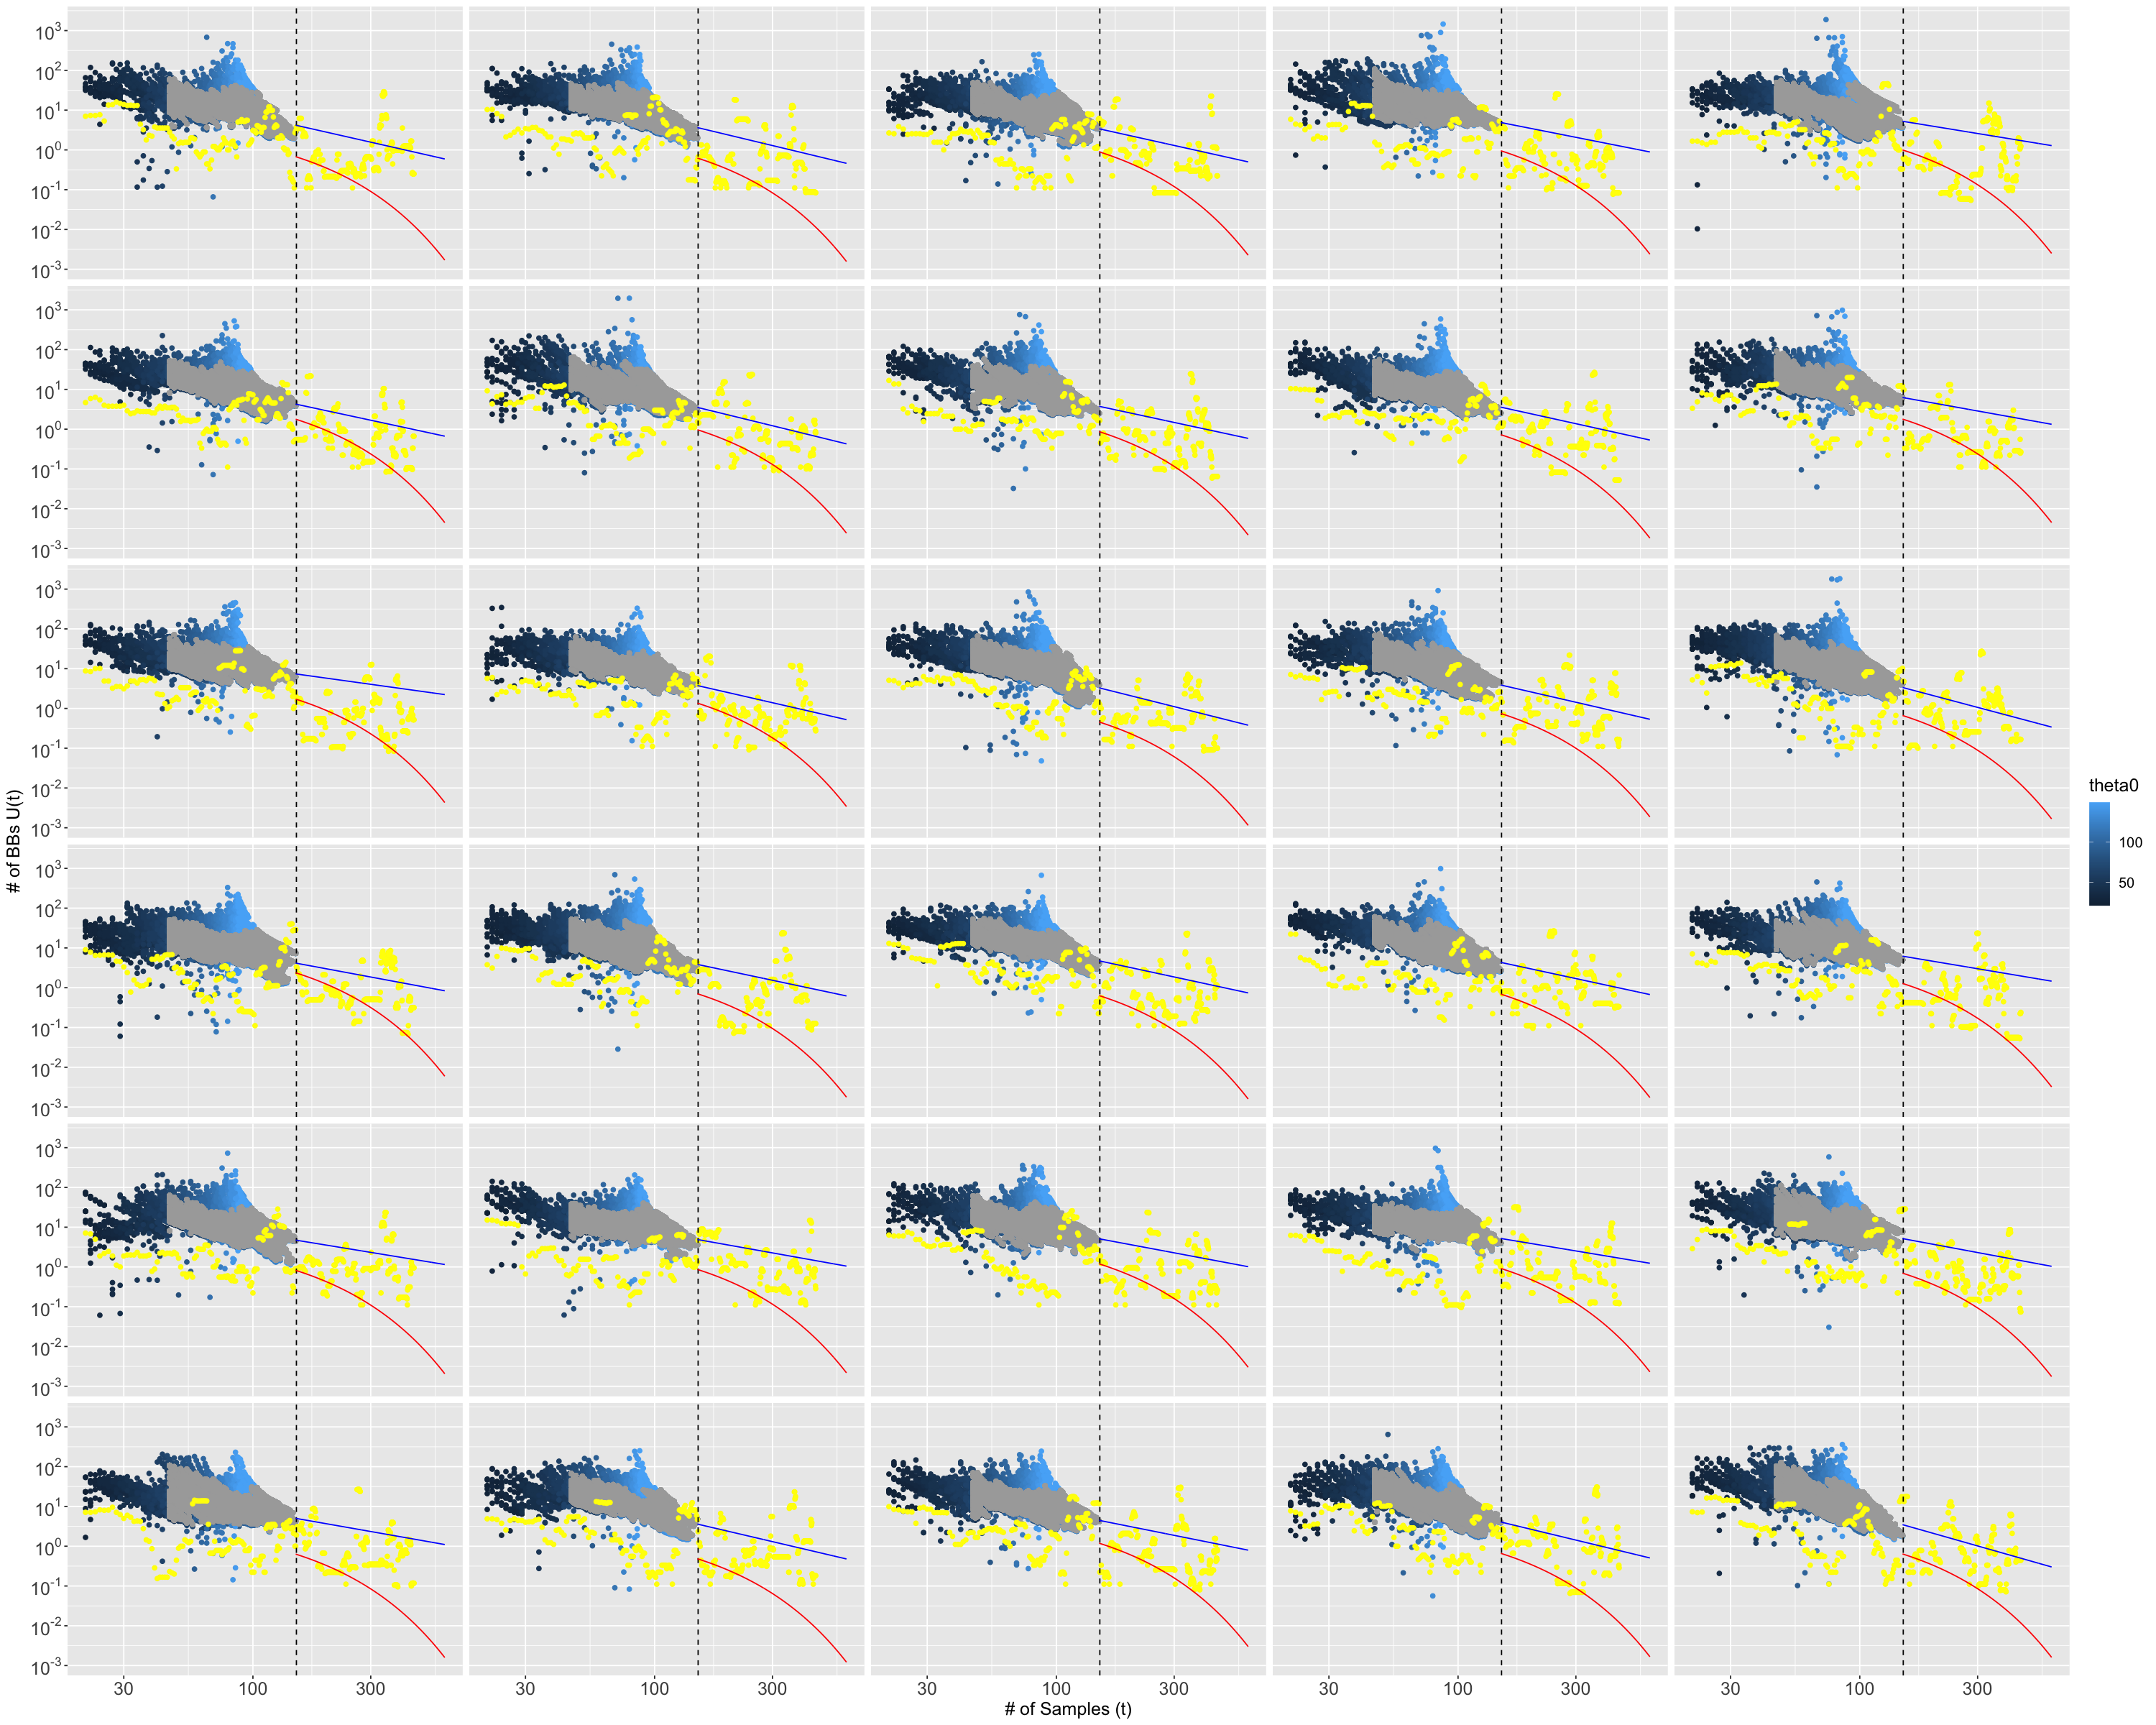

In [9]:
options(repr.plot.width = 25, repr.plot.height = 20)
plt = ggplot() +
    geom_point(data=bb_df %>% filter(theta>20,theta>=round(theta0*bet)),aes(theta,gt,color=theta0)) +
    geom_point(data=train_df %>% filter(theta>20),aes(theta,gt),color="darkgrey") +
    geom_point(data=gt_data %>% filter(theta>20,subject==selected_sub,theta<(3*selected_t0))
                       ,aes(theta,ground_ma),color="yellow") +
    geom_vline(xintercept=selected_t0,linetype="dashed") +
    geom_line(data=extra_df %>% filter(theta>20),aes(theta,delta_new),color="blue") +
    geom_line(data=extra_df %>% filter(theta>20),aes(theta,delta_existing),color="red") +
    #geom_smooth(data=gt_data %>% filter(theta>20,subject==selected_sub,theta<(3*selected_t0)),
    #                                    aes(theta,ground_ma), method = "lm",color="green") + 
    theme(axis.text.x=element_text(size=15),axis.text.y=element_text(size=15),legend.text=element_text(size=12),
          axis.title.y=element_text(size=15),legend.title=element_text(size=15),
          plot.caption = element_text(hjust=0.5),axis.title.x=element_text(size=15),
          strip.text.x = element_blank(),strip.text.y = element_text(size=15)) +
    scale_x_log10("# of Samples (t)") +
    scale_y_log10("# of BBs U(t)",
    breaks = trans_breaks("log10", function(x) 10^x),
    labels = trans_format("log10", math_format(10^.x))) +
    facet_wrap(.~run,ncol=5)

g = grid.arrange(plt, nrow = 1)
ggsave(file="figures/Extrapolate_showcase.png",g,width = 25, height = 20, units = "in", device='png')

### RQ 1 - Extrapolator Performance Evaluation

In [10]:
data_scatter = extrapolated %>%
                filter(theta0>=100) %>%
                merge(gt_data,by=c("subject","run","theta"),all.x=TRUE) %>%
                filter(theta >= theta0) %>%
                group_by(subject,theta,theta0,prop) %>%
                summarize(med_error = mean(ground_ma-delta_new),med_gt = mean(ground_ma), .groups="drop")

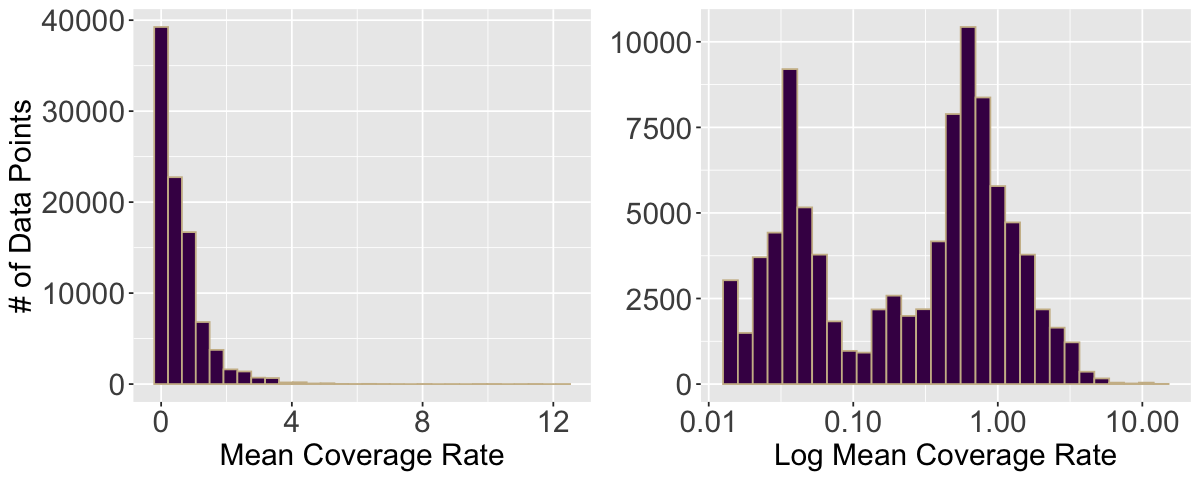

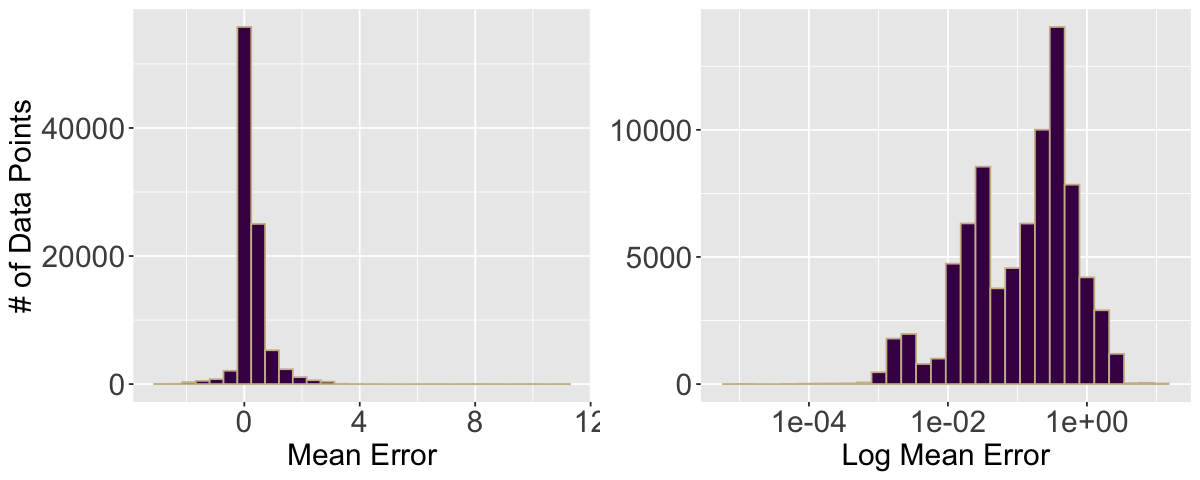

In [11]:
options(repr.plot.width = 10, repr.plot.height = 4)

# Define a color palette from viridis with distinct colors
my_colors = viridis(2, option = "D")  # Use the "D" option for distinct colors

p1 = data_scatter %>% 
    ggplot() +
    geom_histogram(aes(med_gt, fill = "Histogram 1"), bins = 30, col="wheat3") +
    scale_fill_manual(values = my_colors) +
    theme(legend.title = element_blank(), legend.position = "None",
        axis.text.x = element_text(size = 18), axis.title.x = element_text(size = 18),
        axis.text.y = element_text(size = 18), axis.title.y = element_text(size = 18),
        legend.text = element_blank(),
        strip.text.x = element_blank(), strip.text.y = element_text(size = 22)) +
    scale_y_continuous("# of Data Points") +
    scale_x_continuous("Mean Coverage Rate")

p2 = data_scatter %>% 
    ggplot() +
    geom_histogram(aes(med_gt, fill = "Histogram 2"), bins = 30, col="wheat3") +
    scale_fill_manual(values = my_colors) +
    theme(legend.title = element_blank(), legend.position = "None",
        axis.text.x = element_text(size = 18), axis.title.x = element_text(size = 18),
        axis.text.y = element_text(size = 18), axis.title.y = element_blank(),
        legend.text = element_blank(),
        strip.text.x = element_blank(), strip.text.y = element_text(size = 22)) +
    scale_y_continuous("# of Data Points") +
    scale_x_log10("Log Mean Coverage Rate")

p3 = data_scatter %>% 
    ggplot() +
    geom_histogram(aes(med_error, fill = "Histogram 1"), bins = 30, col="wheat3") +
    scale_fill_manual(values = my_colors) +
    theme(legend.title = element_blank(), legend.position = "None",
        axis.text.x = element_text(size = 18), axis.title.x = element_text(size = 18),
        axis.text.y = element_text(size = 18), axis.title.y = element_text(size = 18),
        legend.text = element_blank(),
        strip.text.x = element_blank(), strip.text.y = element_text(size = 22)) +
    scale_y_continuous("# of Data Points") +
    scale_x_continuous("Mean Error")

p4 = data_scatter %>% 
    ggplot() +
    geom_histogram(aes(med_error, fill = "Histogram 2"), bins = 30, col="wheat3") +
    scale_fill_manual(values = my_colors) +
    theme(legend.title = element_blank(), legend.position = "None",
        axis.text.x = element_text(size = 18), axis.title.x = element_text(size = 18),
        axis.text.y = element_text(size = 18), axis.title.y = element_blank(),
        legend.text = element_blank(),
        strip.text.x = element_blank(), strip.text.y = element_text(size = 22)) +
    scale_y_continuous("# of Data Points") +
    scale_x_log10("Log Mean Error")

g = grid.arrange(p1, p2, nrow = 1)
ggsave("figures/Figure-S1.pdf",g,width=10,height=4)

g = grid.arrange(p3, p4, nrow = 1)
ggsave("figures/Figure-S2.pdf",g,width=10,height=4)

In [12]:
## Compute Mean Bias of Extrapolations
bias_df = extrapolated %>%
            filter(theta0>=100) %>%
            merge(gt_data,by=c("subject","run","theta"),all.x=TRUE) %>%
            mutate(delta_existing=log(delta_existing),delta_new=log(delta_new),ground=log(ground_ma)) %>%
            group_by(subject,run,theta0,prop) %>%
            summarize(bias_existing=mean(delta_existing-ground,na.rm=TRUE),
                      bias_new=mean(delta_new-ground,na.rm=TRUE), .groups = "drop") %>%
            ungroup()

bias_df = bias_df %>%
            filter((theta0+prop*theta0)<=max(theta0)) %>%
            group_by(subject,run,theta0,prop) %>%
            pivot_longer(!c(subject,run,theta0,prop),names_to = "method", values_to = "value") %>%
            ungroup()


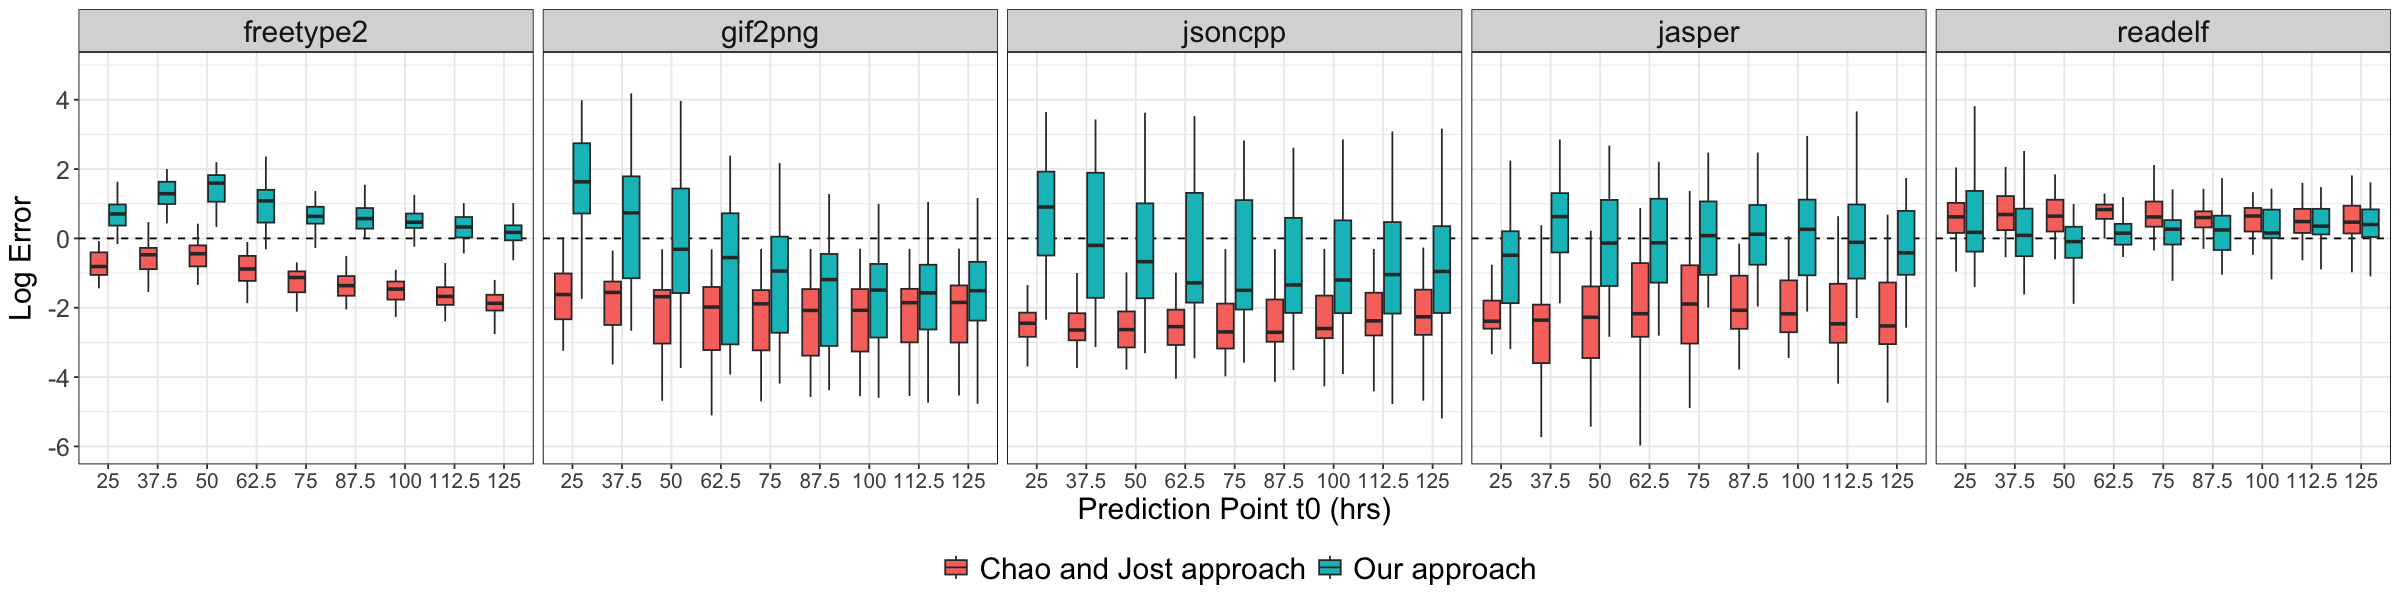

In [13]:
selected_prop = 0.5

bias_result_prop = bias_df %>%
                 filter(prop==selected_prop)

options(repr.plot.width = 20, repr.plot.height = 5)
p1 = bias_result_prop %>%
    filter(method=="bias_existing" | method=="bias_new") %>%
    mutate(method=ifelse(method=="bias_existing","Chao and Jost approach","Our approach")) %>%
    mutate(theta0=as.factor(theta0*(1/4))) %>%
    ggplot() +
    geom_hline(yintercept = 0, linetype = "dashed", color = "black", size = 0.5) +
    geom_boxplot(aes(x=theta0,y=value,fill=method),outlier.shape = NA, outlier.colour = NA) +
    theme_bw() +
    theme(panel.border = element_rect(color = "black"),
    axis.title.x = element_text(size=18), legend.title = element_blank(),legend.position = "bottom",
    legend.text=element_text(size=18),
    axis.text.x=element_text(size=12.5),
    axis.text.y=element_text(size=15),axis.title.y=element_text(size=18),
    strip.text.x = element_text(size=18),strip.text.y = element_text(size=18)) +
    scale_y_continuous("Log Error", breaks = pretty_breaks()) +
    #labels = trans_format("log10", math_format(10^.x)),limits=c(10^(-1),10^(1.5))) + 
    facet_grid(~subject,scales="free") +
    xlab("Prediction Point t0 (hrs)")
                  
plot_grid(p1, ncol = 1, align = "v")
ggsave("figures/Figure-4.pdf",width=20,height=5)

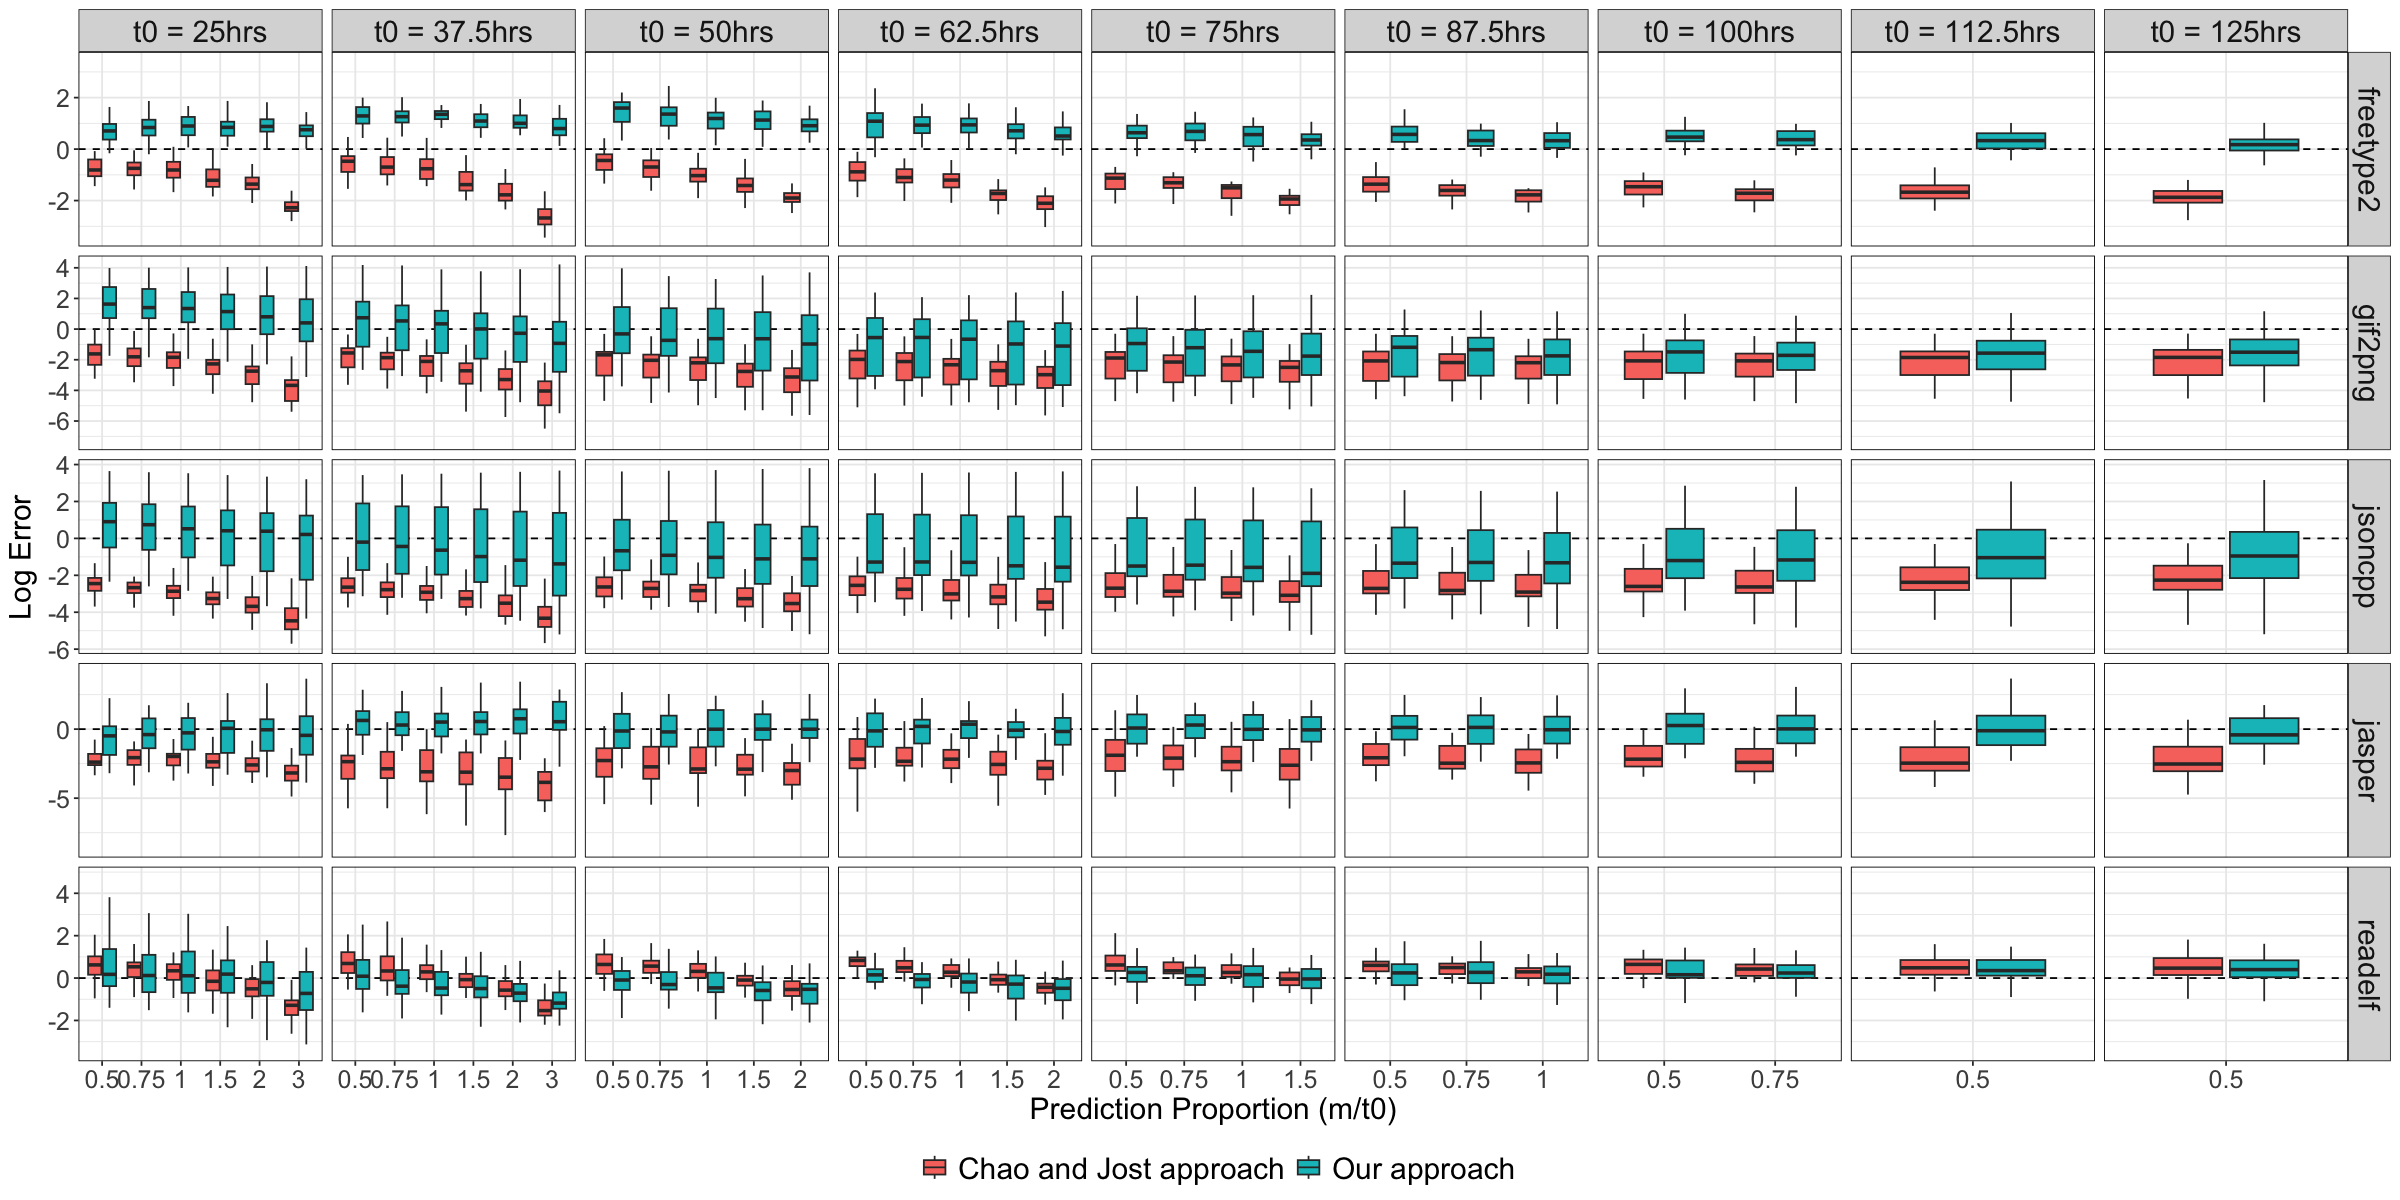

In [14]:
options(repr.plot.width = 20, repr.plot.height = 10)

p1 = bias_df %>%
        filter(method == "bias_existing" | method == "bias_new") %>%
        mutate(method = ifelse(method == "bias_existing", "Chao and Jost approach", "Our approach")) %>%
        arrange(theta0) %>%
        mutate(theta0 = as.factor(theta0 * (1/4))) %>%
        mutate(prop = factor(prop), theta0 = factor(paste("t0 = ", theta0, "hrs", sep = ""),
                                                  c(paste("t0 = ", seq(50, 500, by = 50) * (1/4), "hrs", sep = "")))) %>%
        ggplot() +
        geom_hline(yintercept = 0, linetype = "dashed", color = "black", size = 0.5) +
        geom_boxplot(aes(x = prop, y = value, fill = method),outlier.shape = NA, outlier.colour = NA) +
        labs(x="Prediction Proportion (m/t0)") +
        theme_bw() +
        theme(panel.border = element_rect(color = "black"),
         legend.title = element_blank(),legend.position = "bottom",
         axis.text.x=element_text(size=15),axis.title.x=element_text(size=18),
         axis.text.y=element_text(size=15),axis.title.y=element_text(size=18),
         legend.text=element_text(size=18),
         strip.text.x = element_text(size=18),strip.text.y = element_text(size=18)) +
        scale_y_continuous("Log Error", breaks = pretty_breaks()) + 
        facet_grid(subject~theta0,scales="free")

plot_grid(p1, ncol = 1, align = "v")
ggsave("figures/Figure-5.pdf",width=20,height=15)

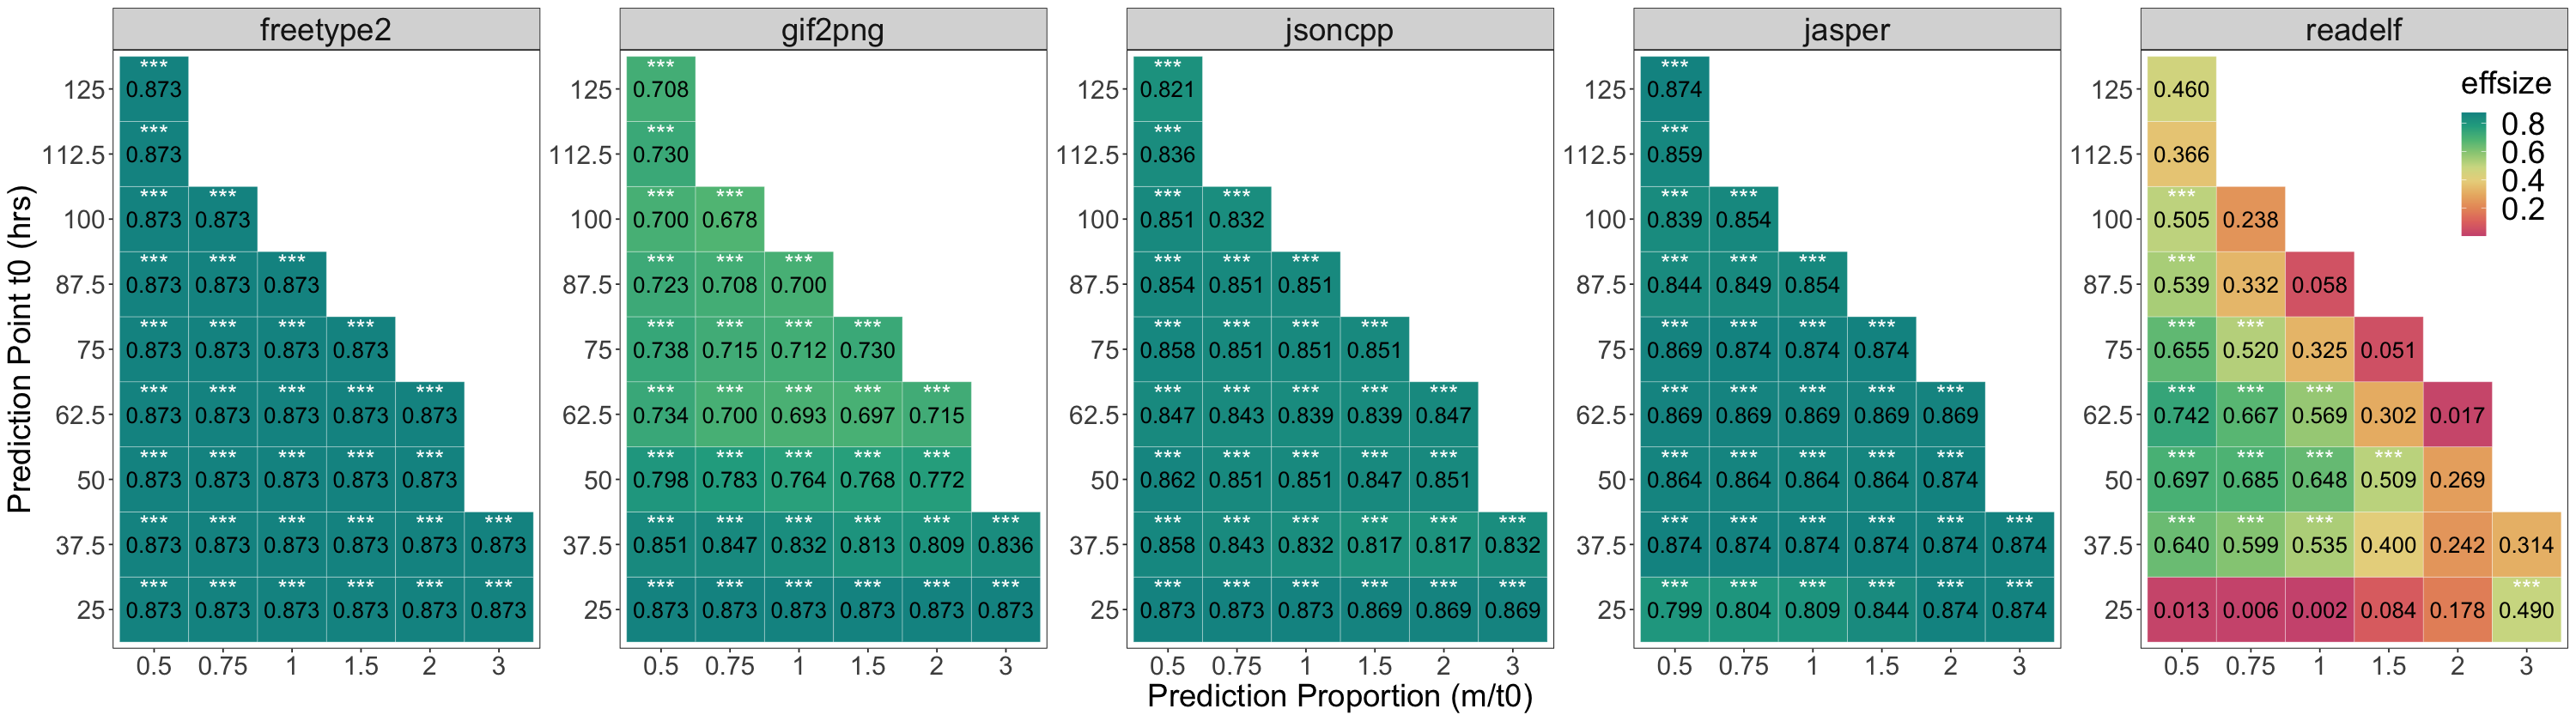

In [15]:
# Heat map
ALTERNATE = "two.sided"
eff_size = merge(
            bias_df %>% 
            filter(method=="bias_existing" | method=="bias_new") %>%
            filter_all(all_vars(!is.infinite(.))) %>%
            drop_na() %>%
            distinct() %>%
            group_by(subject,run,theta0,prop) %>%
            mutate(freq=n()) %>%
            filter(freq==2) %>%
            ungroup() %>%
            group_by(subject,theta0,prop) %>%
            wilcox_effsize(value ~ method,alternate=ALTERNATE,paired=TRUE,conf.level=0.99) %>%
            ungroup() %>%
            select(subject,theta0,prop,effsize),
            bias_df %>% 
            filter(method=="bias_existing" | method=="bias_new") %>%
            filter_all(all_vars(!is.infinite(.))) %>%
            drop_na() %>%
            distinct() %>%
            group_by(subject,run,theta0,prop) %>%
            mutate(freq=n()) %>%
            filter(freq==2) %>%
            ungroup() %>%
            group_by(subject,theta0,prop) %>%
            summarise(p.value=wilcox.test(value ~ method,alternative=ALTERNATE,paired=TRUE,conf.level=0.99)$p.value, 
                      .groups = "drop") %>%
            ungroup(),
            by=c("subject","theta0","prop"))

eff_size = eff_size %>% mutate(theta0=factor(theta0*(1/4)))

eff_size$theta0 = factor(eff_size$theta0, levels=seq(50,max(gb_data$theta),by=50)*(1/4))
eff_size$prop = factor(eff_size$prop, levels=c(0.5,0.75,1,1.5,2,3))

options(repr.plot.width = 25, repr.plot.height = 7)
pp = eff_size %>%
    rename(t0=theta0,proportion=prop) %>%
    ggplot(aes(x = proportion, y = t0, fill = effsize)) +
    geom_tile(color="white") +
    geom_text(aes(label = format(effsize, scientific = FALSE, digits = 1)), color = "black", size = 5.5) +
    geom_text(aes(label = ifelse(p.value<=0.01,"***","")), color = "white", size = 6, vjust = -0.7) +
    scale_fill_gradientn(colors = hcl.colors(10, "Temps", rev = TRUE)) +
    theme_bw() +
    theme(panel.border = element_rect(color = "black"),
         panel.grid.major = element_blank(),panel.grid.minor = element_blank(),
         axis.text.x=element_text(size=18),strip.text.x = element_text(size=22),
         axis.title.x=element_text(size=22),strip.text.y = element_text(size=22),
         axis.text.y=element_text(size=18),
         axis.title.y=element_text(size=22),
         legend.text=element_text(size=22),
         legend.title=element_text(size=22),legend.position=c(0.975,0.83)) +
    xlab("Prediction Proportion (m/t0)") + 
    ylab("Prediction Point t0 (hrs)") +
    facet_wrap(~subject,scales="free",nrow=1)

g = grid.arrange(pp, nrow = 1)
ggsave("figures/Figure-6.pdf",g,width=25,height=7)

### Cost-Benefit Analysis

In [16]:
prediction_fit = extrapolated %>%
                filter(theta0>=100) %>% 
                merge(gt_data,by=c("subject","run","theta"),all.x=TRUE) %>%
                filter(theta >= theta0) %>%
                #filter((theta0+prop*theta0)<=max(theta0)) %>%
                select(subject,run,theta,theta0,prop,delta_existing,delta_new,ground_ma,mean_sn) #%>%
                #mutate(delta_existing=log(delta_existing),delta_new=log(delta_new),ground=log(ground_ma)) #%>%
                #filter(delta_new>0,delta_existing>0,ground_ma>0) 

In [17]:
prediction_fit

subject   run theta theta0 prop delta_existing delta_new  ground_ma
1       freetype2 1   100   100    1.00 1.540805       6.637102   3.111111 
2       freetype2 1   100   100    0.75 1.540805       6.637102   3.111111 
3       freetype2 1   100   100    2.00 1.540805       6.637102   3.111111 
4       freetype2 1   100   100    1.50 1.540805       6.637102   3.111111 
5       freetype2 1   100   100    0.50 1.540805       6.637102   3.111111 
6       freetype2 1   100   100    3.00 1.540805       6.637102   3.111111 
7       freetype2 1   101   100    1.00 1.510294       6.544482   3.000000 
8       freetype2 1   101   100    3.00 1.510294       6.544482   3.000000 
9       freetype2 1   101   100    0.75 1.510294       6.544482   3.000000 
10      freetype2 1   101   100    2.00 1.510294       6.544482   3.000000 
11      freetype2 1   101   100    1.50 1.510294       6.544482   3.000000 
12      freetype2 1   101   100    0.50 1.510294       6.544482   3.000000 
13      freetype2 1   102   100    2.00 1.480387       6.454040   3.000000 
14      freetype2 1   102   100    3.00 1.480387       6.454040   3.000000 
15      freetype2 1   102   100    1.00 1.480387       6.454040   3.000000 
16      freetype2 1   102   100    1.50 1.480387       6.454040   3.000000 
17      freetype2 1   102   100    0.75 1.480387       6.454040   3.000000 
18      freetype2 1   102   100    0.50 1.480387       6.454040   3.000000 
19      freetype2 1   103   100    1.50 1.451073       6.365703   2.666667 
20      freetype2 1   103   100    0.75 1.451073       6.365703   2.666667 
21      freetype2 1   103   100    2.00 1.451073       6.365703   2.666667 
22      freetype2 1   103   100    1.00 1.451073       6.365703   2.666667 
23      freetype2 1   103   100    0.50 1.451073       6.365703   2.666667 
24      freetype2 1   103   100    3.00 1.451073       6.365703   2.666667 
25      freetype2 1   104   100    2.00 1.422339       6.279404   4.111111 
26      freetype2 1   104   100    1.00 1.422339       6.279404   4.111111 
27      freetype2 1   104   100    1.50 1.422339       6.279404   4.111111 
28      freetype2 1   104   100    0.75 1.422339       6.279404   4.111111 
29      freetype2 1   104   100    0.50 1.422339       6.279404   4.111111 
30      freetype2 1   104   100    3.00 1.422339       6.279404   4.111111 
...     ...       ... ...   ...    ...  ...            ...        ...      
2540807 readelf   9   768   400    1.50 0.123552440    0.11562509 0.2      
2540808 readelf   9   768   500    1.50 0.213468144    0.27733441 0.2      
2540809 readelf   9   768   500    1.00 0.213468144    0.27733441 0.2      
2540810 readelf   9   768   300    3.00 0.044579624    0.01810031 0.2      
2540811 readelf   9   768   600    1.50 0.295266301    0.35734246 0.2      
2540812 readelf   9   768   400    1.00 0.123552440    0.11562509 0.2      
2540813 readelf   9   768   650    1.00 0.332050152    0.34239804 0.2      
2540814 readelf   9   768   400    2.00 0.123552440    0.11562509 0.2      
2540815 readelf   9   768   200    3.00 0.004187564    0.01150572 0.2      
2540816 readelf   9   768   550    1.50 0.255075058    0.33467731 0.2      
2540817 readelf   9   768   650    0.50 0.332050152    0.34239804 0.2      
2540818 readelf   9   768   600    0.75 0.295266301    0.35734246 0.2      
2540819 readelf   9   768   500    0.75 0.213468144    0.27733441 0.2      
2540820 readelf   9   768   550    2.00 0.255075058    0.33467731 0.2      
2540821 readelf   9   768   550    0.75 0.255075058    0.33467731 0.2      
2540822 readelf   9   768   400    3.00 0.123552440    0.11562509 0.2      
2540823 readelf   9   768   300    2.00 0.044579624    0.01810031 0.2      
2540824 readelf   9   768   450    3.00 0.169073466    0.20180665 0.2      
2540825 readelf   9   768   650    1.50 0.332050152    0.34239804 0.2      
2540826 readelf   9   768   500    2.00 0.213468144    0.27733441 0.2      
2540827 readelf   9   768   600    1.00 0.295266301    0

In [120]:
k <- 50
# r <- 0.1

thresh_df <- prediction_fit %>%
    group_by(subject) %>%
    arrange(theta) %>%
    summarise(threshold = median(ground_ma), .groups = "drop") %>%
    ungroup()

subjects <- thresh_df$subject
thresholds <- thresh_df$threshold

fit_df <- tibble()

for (i in 1:length(subjects)) {
    selected_sub <- subjects[i]
    threshold <- thresholds[i]

    fit_new <- prediction_fit %>%
        filter(subject == selected_sub) %>%
        mutate(threshold = threshold, passed_cutoff = ifelse(threshold > delta_new, 1, 0)) %>%
        group_by(subject, run, theta0, threshold) %>%
        arrange(theta) %>%
        filter(passed_cutoff == 1) %>%
        mutate(pivotal_point = ifelse(abs(delta_new - threshold) == min(abs(delta_new - threshold)), theta, 0)) %>%
        mutate(take = ifelse(k >= abs(theta - max(pivotal_point)), 1, 0)) %>%
        # mutate(take = ifelse(r >= (abs(max(pivotal_point) - theta) / max(pivotal_point)), 1, 0)) %>%
        select(-prop) %>%
        distinct() %>%
        summarise(
            theta = theta[pivotal_point > 0], delta_new = delta_new[pivotal_point > 0],
            avg_ground_new = mean(ground_ma[take == 1]), .groups = "drop"
        ) %>%
        ungroup() %>%
        mutate(deviation_new = avg_ground_new - delta_new, theta_new = theta, deviation_new_rel = deviation_new / threshold)

    fit_existing <- prediction_fit %>%
        filter(subject == selected_sub) %>%
        mutate(threshold = threshold, passed_cutoff = ifelse(threshold > delta_existing, 1, 0)) %>%
        group_by(subject, run, theta0, threshold) %>%
        arrange(theta) %>%
        filter(passed_cutoff == 1) %>%
        mutate(pivotal_point = ifelse(abs(delta_existing - threshold) == min(abs(delta_existing - threshold)), theta, 0)) %>%
        mutate(take = ifelse(k >= abs(theta - max(pivotal_point)), 1, 0)) %>%
        # mutate(take = ifelse(r >= (abs(max(pivotal_point) - theta) / max(pivotal_point)), 1, 0)) %>%
        select(-prop) %>%
        distinct() %>%
        summarise(
            theta = theta[pivotal_point > 0], delta_existing = delta_existing[pivotal_point > 0],
            avg_ground_existing = mean(ground_ma[take == 1]), .groups = "drop"
        ) %>%
        ungroup() %>%
        mutate(deviation_existing = avg_ground_existing - delta_existing, theta_existing = theta, deviation_existing_rel = deviation_existing / threshold)

    combined <- merge(fit_new, fit_existing, by = c("subject", "run", "theta0", "threshold"))
    fit_df <- rbind(fit_df, combined)
}

fit_df <- fit_df %>%
    select(subject, run, theta0, threshold, deviation_new, deviation_existing, deviation_new_rel, deviation_existing_rel) %>%
    pivot_longer(!c(subject, run, theta0, threshold), names_to = "method", values_to = "value")

fit_df <- fit_df %>%
    group_by(subject, run, theta0, threshold) %>%
    mutate(count = n()) %>%
    filter(count == 4)


In [121]:
options(repr.plot.width = 15, repr.plot.height = 25)

axes <- list()
idx <- 1
for (sub in c("freetype2", "gif2png", "jsoncpp", "jasper", "readelf")) {
    sub_df <- fit_df[(fit_df["subject"] == sub), ] %>%
        dcast(subject + run + theta0 + threshold ~ method, value.var = "value") %>%
        mutate(diff = abs(deviation_existing) - abs(deviation_new)) %>%
        mutate(diff_rel = abs(deviation_existing_rel) - abs(deviation_new_rel)) %>%
        mutate(theta0 = as.factor(theta0))
    # sub_df without outliers
    dev_exist_rel_min <- quantile(sub_df$deviation_existing_rel, 0.25) - 1.5 * IQR(sub_df$deviation_existing_rel)
    dev_exist_rel_max <- quantile(sub_df$deviation_existing_rel, 0.75) + 1.5 * IQR(sub_df$deviation_existing_rel)
    dev_new_rel_min <- quantile(sub_df$deviation_new_rel, 0.25) - 1.5 * IQR(sub_df$deviation_new_rel)
    dev_new_rel_max <- quantile(sub_df$deviation_new_rel, 0.75) + 1.5 * IQR(sub_df$deviation_new_rel)
    diff_rel_min <- quantile(sub_df$diff_rel, 0.25) - 1.5 * IQR(sub_df$diff_rel)
    diff_rel_max <- quantile(sub_df$diff_rel, 0.75) + 1.5 * IQR(sub_df$diff_rel)
    axes[[idx]] <- sub_df %>%
        ggplot() +
        geom_boxplot(aes(x = theta0, y = deviation_existing_rel), outlier.shape = NA, outlier.colour = NA) +
        geom_hline(yintercept = 0, linetype = "dashed", color = "black", size = 0.5) +
        theme_bw() +
        scale_y_continuous(limits = c(
            min(c(dev_exist_rel_min, dev_new_rel_min)),
            max(c(dev_exist_rel_max, dev_new_rel_max))
        ))
    idx <- idx + 1
    axes[[idx]] <- sub_df %>%
        ggplot() +
        geom_boxplot(aes(x = theta0, y = deviation_new_rel), outlier.shape = NA, outlier.colour = NA) +
        geom_hline(yintercept = 0, linetype = "dashed", color = "black", size = 0.5) +
        theme_bw() +
        scale_y_continuous(limits = c(
            min(c(dev_exist_rel_min, dev_new_rel_min)),
            max(c(dev_exist_rel_max, dev_new_rel_max))
        ))
    idx <- idx + 1
    axes[[idx]] <- sub_df %>%
        ggplot() +
        geom_boxplot(aes(x = theta0, y = diff_rel), outlier.shape = NA, outlier.colour = NA) +
        geom_hline(yintercept = 0, linetype = "dashed", color = "black", size = 0.5) +
        theme_bw() +
        scale_y_continuous(limits = c(
            diff_rel_min, diff_rel_max
        ))
    idx <- idx + 1
}

g = ggarrange(
    axes[[1]], axes[[2]], axes[[3]], axes[[4]], axes[[5]],
    axes[[6]], axes[[7]], axes[[8]], axes[[9]], axes[[10]],
    axes[[11]], axes[[12]], axes[[13]], axes[[14]], axes[[15]],
    nrow = 5, ncol = 3
)

# save plt
ggsave("figures/RQ1-B-k-50.pdf", g, width = 15, height = 25)

In [126]:
install.packages("effsize")


The downloaded binary packages are in
	/var/folders/v9/wc5dh1fd691947y71hyt_2280000gn/T//RtmptZHNF6/downloaded_packages


In [ ]:
sub_df = fit_df %>%
        group_by(subject,run,theta0,threshold) %>% 
        dcast(subject + run + theta0 + threshold ~ method, value.var = "value") %>%
        mutate(diff = abs(deviation_existing) - abs(deviation_new)) %>%
        mutate(diff_rel = abs(deviation_existing_rel) - abs(deviation_new_rel)) %>%
        mutate(theta0 = as.factor(theta0),
    # sub_df without outliers
    dev_exist_rel_min = quantile(sub_df$deviation_existing_rel, 0.25) - 1.5 * IQR(sub_df$deviation_existing_rel),
    dev_exist_rel_max = quantile(sub_df$deviation_existing_rel, 0.75) + 1.5 * IQR(sub_df$deviation_existing_rel),
    dev_new_rel_min = quantile(sub_df$deviation_new_rel, 0.25) - 1.5 * IQR(sub_df$deviation_new_rel),
    dev_new_rel_max = quantile(sub_df$deviation_new_rel, 0.75) + 1.5 * IQR(sub_df$deviation_new_rel),
    diff_rel_min = quantile(sub_df$diff_rel, 0.25) - 1.5 * IQR(sub_df$diff_rel),
    diff_rel_max = quantile(sub_df$diff_rel, 0.75) + 1.5 * IQR(sub_df$diff_rel)) %>%
    filter(deviation_existing_rel >= dev_exist_rel_min, deviation_existing_rel <= dev_exist_rel_max,
           deviation_new_rel >= dev_new_rel_min, deviation_new_rel <= dev_new_rel_max) %>%
    select(subject,run,theta0,threshold,deviation_existing_rel,deviation_new_rel) %>%
    pivot_longer(!c(subject, run, theta0, threshold), names_to = "method", values_to = "value")
    

In [ ]:
sub_df = fit_df %>%
        group_by(subject,run,theta0,threshold) %>% 
        dcast(subject + run + theta0 + threshold ~ method, value.var = "value") %>%
        mutate(diff = abs(deviation_existing) - abs(deviation_new)) %>%
        mutate(diff_rel = abs(deviation_existing_rel) - abs(deviation_new_rel)) %>%
        mutate(theta0 = as.factor(theta0),
    # sub_df without outliers
    dev_exist_rel_min = quantile(sub_df$deviation_existing_rel, 0.25) - 1.5 * IQR(sub_df$deviation_existing_rel),
    dev_exist_rel_max = quantile(sub_df$deviation_existing_rel, 0.75) + 1.5 * IQR(sub_df$deviation_existing_rel),
    dev_new_rel_min = quantile(sub_df$deviation_new_rel, 0.25) - 1.5 * IQR(sub_df$deviation_new_rel),
    dev_new_rel_max = quantile(sub_df$deviation_new_rel, 0.75) + 1.5 * IQR(sub_df$deviation_new_rel),
    diff_rel_min = quantile(sub_df$diff_rel, 0.25) - 1.5 * IQR(sub_df$diff_rel),
    diff_rel_max = quantile(sub_df$diff_rel, 0.75) + 1.5 * IQR(sub_df$diff_rel)) %>%
    filter(deviation_existing_rel >= dev_exist_rel_min, deviation_existing_rel <= dev_exist_rel_max,
           deviation_new_rel >= dev_new_rel_min, deviation_new_rel <= dev_new_rel_max) %>%
    select(subject,run,theta0,threshold,deviation_existing_rel,deviation_new_rel) %>%
    pivot_longer(!c(subject, run, theta0, threshold), names_to = "method", values_to = "value")
    

In [133]:
# Median
fit_df %>%
    dcast(subject + run + theta0 + threshold ~ method, value.var = "value") %>%
    mutate(diff = abs(deviation_existing) - abs(deviation_new)) %>%
    mutate(diff_rel = abs(deviation_existing_rel) - abs(deviation_new_rel)) %>%
    mutate(theta0 = as.factor(theta0)) %>%
    ungroup() %>%
    group_by(subject) %>%
    summarise(
        # mean_dev_exist_rel = mean(deviation_existing_rel),
        # mean_dev_new_rel = mean(deviation_new_rel),
        median_dev_exist_rel = median(deviation_existing_rel),
        median_dev_new_rel = median(deviation_new_rel),
        .groups = "drop"
    ) %>%
    ungroup() %>%
    # save
    write.csv("figures/RQ1-B-k-37.5-median.csv", row.names = FALSE)

# Statistical test
data <- matrix(nrow = 5, ncol = 3)
ridx <- 1
for (sub in c("freetype2", "gif2png", "jsoncpp", "jasper", "readelf")) {
    sub_df <- fit_df[(fit_df["subject"] == sub), ] %>%
        dcast(subject + run + theta0 + threshold ~ method, value.var = "value") %>%
        ungroup()
    # statistical tests
    p_value <- wilcox.test(abs(sub_df$deviation_existing_rel), abs(sub_df$deviation_new_rel), paired = TRUE, conf.level = 0.95, alternative = "greater")$p.value
    test_result <- (sub_df %>%
        select(deviation_existing_rel, deviation_new_rel) %>%
        mutate(deviation_existing_rel = abs(deviation_existing_rel), deviation_new_rel = abs(deviation_new_rel)) %>%
        melt() %>%
        wilcox_effsize(value ~ variable, paired = TRUE, conf.level = 0.95, alternative = "greater"))
    eff_size <- test_result$effsize
    print(paste(sub, "p-value:", p_value, "effect size:", eff_size))
    data[ridx, ] <- c(sub, p_value, eff_size)
    ridx <- ridx + 1
}
colnames(data) <- c("subject", "p-value", "effect size")
write.csv(data, "figures/RQ1-B-k-37.5-stat.csv", row.names = FALSE)


No id variables; using all as measure variables



[1] "freetype2 p-value: 8.66039777436388e-08 effect size: 0.335970064411346"


No id variables; using all as measure variables



[1] "gif2png p-value: 6.77549634343262e-24 effect size: 0.525487086337216"


No id variables; using all as measure variables



[1] "jsoncpp p-value: 3.20280389874561e-22 effect size: 0.553749508291568"


No id variables; using all as measure variables



[1] "jasper p-value: 0.0414834119583938 effect size: 0.115873802813956"


No id variables; using all as measure variables



[1] "readelf p-value: 0.783179913040474 effect size: 0.0591312395989083"


In [ ]:
# options(repr.plot.width = 15, repr.plot.height = 25)

# axes <- list()
# idx <- 1
# for (sub in c("freetype2", "gif2png", "jsoncpp", "jasper", "readelf")) {
#     sub_df <- fit_df[(fit_df["subject"] == sub), ] %>%
#         dcast(subject + run + theta0 + threshold ~ method, value.var = "value") %>%
#         mutate(diff = abs(deviation_existing) - abs(deviation_new)) %>%
#         mutate(diff_rel = abs(deviation_existing_rel) - abs(deviation_new_rel)) %>%
#         mutate(theta0 = as.factor(theta0))
#     axes[[idx]] <- sub_df %>%
#         ggplot() +
#         geom_boxplot(aes(x = theta0, y = deviation_existing_rel)) +
#         geom_hline(yintercept = 0, linetype = "dashed", color = "black", size = 0.5) +
#         theme_bw() +
#         scale_y_continuous(limits = c(
#             min(c(sub_df$deviation_existing_rel, sub_df$deviation_new_rel)),
#             max(c(sub_df$deviation_existing_rel, sub_df$deviation_new_rel))
#         ))
#     idx <- idx + 1
#     axes[[idx]] <- sub_df %>%
#         ggplot() +
#         geom_boxplot(aes(x = theta0, y = deviation_new_rel)) +
#         geom_hline(yintercept = 0, linetype = "dashed", color = "black", size = 0.5) +
#         theme_bw() +
#         scale_y_continuous(limits = c(
#             min(c(sub_df$deviation_existing_rel, sub_df$deviation_new_rel)),
#             max(c(sub_df$deviation_existing_rel, sub_df$deviation_new_rel))
#         ))
#     idx <- idx + 1
#     # remove outliers
#     axes[[idx]] <- sub_df %>%
#         ggplot() +
#         geom_boxplot(aes(x = theta0, y = diff_rel)) +
#         geom_hline(yintercept = 0, linetype = "dashed", color = "black", size = 0.5) +
#         theme_bw()
#     idx <- idx + 1
# }

# ggarrange(
#     axes[[1]], axes[[2]], axes[[3]], axes[[4]], axes[[5]],
#     axes[[6]], axes[[7]], axes[[8]], axes[[9]], axes[[10]],
#     axes[[11]], axes[[12]], axes[[13]], axes[[14]], axes[[15]],
#     nrow = 5, ncol = 3
# )


# options(repr.plot.width = 15, repr.plot.height = 25)

# axes <- list()
# idx <- 1
# for (sub in c("freetype2", "gif2png", "jsoncpp", "jasper", "readelf")) {
#     sub_df <- fit_df[(fit_df["subject"] == sub), ] %>%
#         dcast(subject + run + theta0 + threshold ~ method, value.var = "value") %>%
#         mutate(diff = abs(deviation_existing) - abs(deviation_new)) %>%
#         mutate(diff_rel = abs(deviation_existing_rel) - abs(deviation_new_rel)) %>%
#         mutate(theta0 = as.factor(theta0))
#     axes[[idx]] <- sub_df %>%
#         ggplot() +
#         geom_boxplot(aes(x = theta0, y = deviation_existing_rel)) +
#         geom_hline(yintercept = 0, linetype = "dashed", color = "black", size = 0.5) +
#         theme_bw() +
#         scale_y_continuous(limits = c(
#             min(c(sub_df$deviation_existing_rel, sub_df$deviation_new_rel)),
#             max(c(sub_df$deviation_existing_rel, sub_df$deviation_new_rel))
#         ))
#     idx <- idx + 1
#     axes[[idx]] <- sub_df %>%
#         ggplot() +
#         geom_boxplot(aes(x = theta0, y = deviation_new_rel)) +
#         geom_hline(yintercept = 0, linetype = "dashed", color = "black", size = 0.5) +
#         theme_bw() +
#         scale_y_continuous(limits = c(
#             min(c(sub_df$deviation_existing_rel, sub_df$deviation_new_rel)),
#             max(c(sub_df$deviation_existing_rel, sub_df$deviation_new_rel))
#         ))
#     idx <- idx + 1
#     # remove outliers
#     diff_rel_min <- quantile(sub_df$diff_rel, 0.25) - 1.5 * IQR(sub_df$diff_rel)
#     diff_rel_max <- quantile(sub_df$diff_rel, 0.75) + 1.5 * IQR(sub_df$diff_rel)
#     axes[[idx]] <- sub_df %>%
#         ggplot() +
#         geom_boxplot(aes(x = theta0, y = diff_rel), outlier.shape = NA, outlier.colour = NA) +
#         geom_hline(yintercept = 0, linetype = "dashed", color = "black", size = 0.5) +
#         theme_bw() +
#         scale_y_continuous(limits = c(diff_rel_min, diff_rel_max))
#     idx <- idx + 1
# }

# ggarrange(
#     axes[[1]], axes[[2]], axes[[3]], axes[[4]], axes[[5]],
#     axes[[6]], axes[[7]], axes[[8]], axes[[9]], axes[[10]],
#     axes[[11]], axes[[12]], axes[[13]], axes[[14]], axes[[15]],
#     nrow = 5, ncol = 3
# )


In [197]:
thresh_df = prediction_fit %>%
            group_by(subject,run) %>%
            arrange(theta) %>%
            summarise(threshold = median(ground_ma), .groups = "drop") %>%
            ungroup()

subjects = thresh_df$subject
#thresholds = thresh_df$threshold
k = 10

fit_df = tibble()

#prediction_fit = prediction_fit %>% merge(thresh_df,by=c("subject","run"))

for(i in 1:length(subjects)){
   selected_sub = subjects[i]
    threshold = thresholds[i]
    
   fit_new = prediction_fit %>%
        filter(subject==selected_sub,run==j) %>%
        mutate(passed_cutoff = ifelse(threshold>delta_new,1,0)) %>%
        group_by(subject,run,theta0,threshold) %>%
        arrange(theta) %>% 
        filter(passed_cutoff==1) %>%
        mutate(pivotal_point = ifelse(abs(delta_new-threshold)==min(abs(delta_new-threshold)),theta,0)) %>%
        mutate(take = ifelse(k>=(theta-max(pivotal_point)),1,0)) %>%
        select(-prop) %>%
        distinct() %>%
        summarise(theta = theta[pivotal_point>0],delta_new = delta_new[pivotal_point>0],
                  avg_ground_new = mean(ground_ma[take==1]), .groups="drop") %>%
        ungroup() %>%
        mutate(deviation_new = avg_ground_new-delta_new,theta_new = theta)

    fit_existing = prediction_fit %>%
        filter(subject==selected_sub,run==j) %>%
        mutate(passed_cutoff = ifelse(threshold>delta_existing,1,0)) %>%
        group_by(subject,run,theta0,threshold) %>%
        arrange(theta) %>%
        filter(passed_cutoff==1) %>%
        mutate(pivotal_point = ifelse(abs(delta_new-threshold)==min(abs(delta_new-threshold)),theta,0)) %>%
        mutate(take = ifelse(k>=(theta-max(pivotal_point)),1,0)) %>%
        select(-prop) %>%
        distinct() %>%
        summarise(theta = theta[pivotal_point>0],delta_existing = delta_existing[pivotal_point>0],
                  avg_ground_existing = mean(ground_ma[take==1]), .groups="drop") %>%
        ungroup() %>%
        mutate(deviation_existing = avg_ground_existing-delta_existing,theta_existing = theta) 
    
    combined = merge(fit_new,fit_existing,by=c("subject","run","theta0","threshold"))
    fit_df = rbind(fit_df,combined)
}

fit_df = fit_df %>% 
            select(subject,run,theta0,threshold,deviation_new,deviation_existing) %>%
            pivot_longer(!c(subject,run,theta0,threshold),names_to = "method", values_to = "value")

#fit_df = fit_df %>%
#            group_by(subject,run,theta0,threshold) %>%
#            mutate(count = n()) %>%
#            filter(count==2)

head(fit_df)

ERROR: [1m[33mError[39m in `filter()`:[22m
[1m[22m[36mi[39m In argument: `run == j`.
[1mCaused by error:[22m
[33m![39m object 'j' not found


In [19]:
thresh_df = prediction_fit %>%
            group_by(subject,run) %>%
            arrange(theta) %>%
            summarise(threshold = median(ground_ma), .groups = "drop") %>%
            ungroup()

subjects = thresh_df$subject
#thresholds = thresh_df$threshold
k = 5

fit_df = tibble()

#prediction_fit = prediction_fit %>% merge(thresh_df,by=c("subject","run"))

for(i in 1:length(subjects)){
   selected_sub = subjects[i]
    
   fit_new = prediction_fit %>%
        filter(subject==selected_sub) %>%
        mutate(passed_cutoff = ifelse(threshold>delta_new,1,0)) %>%
        group_by(subject,run,theta0,threshold) %>%
        arrange(theta) %>% 
        #filter(passed_cutoff==1) %>%
        mutate(pivotal_point = ifelse(abs(delta_new-threshold)==min(abs(delta_new-threshold)),theta,0)) %>%
        mutate(take = ifelse(k>=(theta-max(pivotal_point)),1,0)) %>%
        select(-prop) %>%
        distinct() %>%
        summarise(theta = theta[pivotal_point>0],delta_new = delta_new[pivotal_point>0],
                  avg_ground_new = mean(ground_ma[take==1]), .groups="drop") %>%
        ungroup() %>%
        mutate(deviation_new = avg_ground_new-delta_new,theta_new = theta)

    fit_existing = prediction_fit %>%
        filter(subject==selected_sub) %>%
        mutate(passed_cutoff = ifelse(threshold>delta_existing,1,0)) %>%
        group_by(subject,run,theta0,threshold) %>%
        arrange(theta) %>%
        #filter(passed_cutoff==1) %>%
        mutate(pivotal_point = ifelse(abs(delta_new-threshold)==min(abs(delta_new-threshold)),theta,0)) %>%
        mutate(take = ifelse(k>=(theta-max(pivotal_point)),1,0)) %>%
        select(-prop) %>%
        distinct() %>%
        summarise(theta = theta[pivotal_point>0],delta_existing = delta_existing[pivotal_point>0],
                  avg_ground_existing = mean(ground_ma[take==1]), .groups="drop") %>%
        ungroup() %>%
        mutate(deviation_existing = avg_ground_existing-delta_existing,theta_existing = theta) 
    
    combined = merge(fit_new,fit_existing,by=c("subject","run","theta0","threshold"))
    fit_df = rbind(fit_df,combined)
}

fit_df = fit_df %>% 
            select(subject,run,theta0,threshold,deviation_new,deviation_existing) %>%
            pivot_longer(!c(subject,run,theta0,threshold),names_to = "method", values_to = "value")

#fit_df = fit_df %>%
#            group_by(subject,run,theta0,threshold) %>%
#            mutate(count = n()) %>%
#            filter(count==2)

head(fit_df)

ERROR: [1m[33mError[39m in `group_by()`:[22m
[1m[22m[33m![39m Must group by variables found in `.data`.
[31mx[39m Column `threshold` is not found.


In [ ]:
fit_df %>%
group_by(subject,theta0,threshold,method) %>%
summarise(lower_ci = abc.ci(data=value,statistic=median(na.rm=FALSE),conf=0.95))

Installing package into ‘/home/danushka/R/x86_64-pc-linux-gnu-library/3.6’
(as ‘lib’ is unspecified)



ERROR: Error in library("bootstrapper"): there is no package called ‘bootstrapper’


In [60]:
fit_df %>% select(subject,run) %>% distinct() %>%
group_by(subject) %>%
summarise(count = n())

Adding missing grouping variables: `theta0`, `threshold`


subject   count
1 freetype2 242  
2 gif2png   363  
3 jsoncpp   302  
4 jasper    224  
5 readelf   175

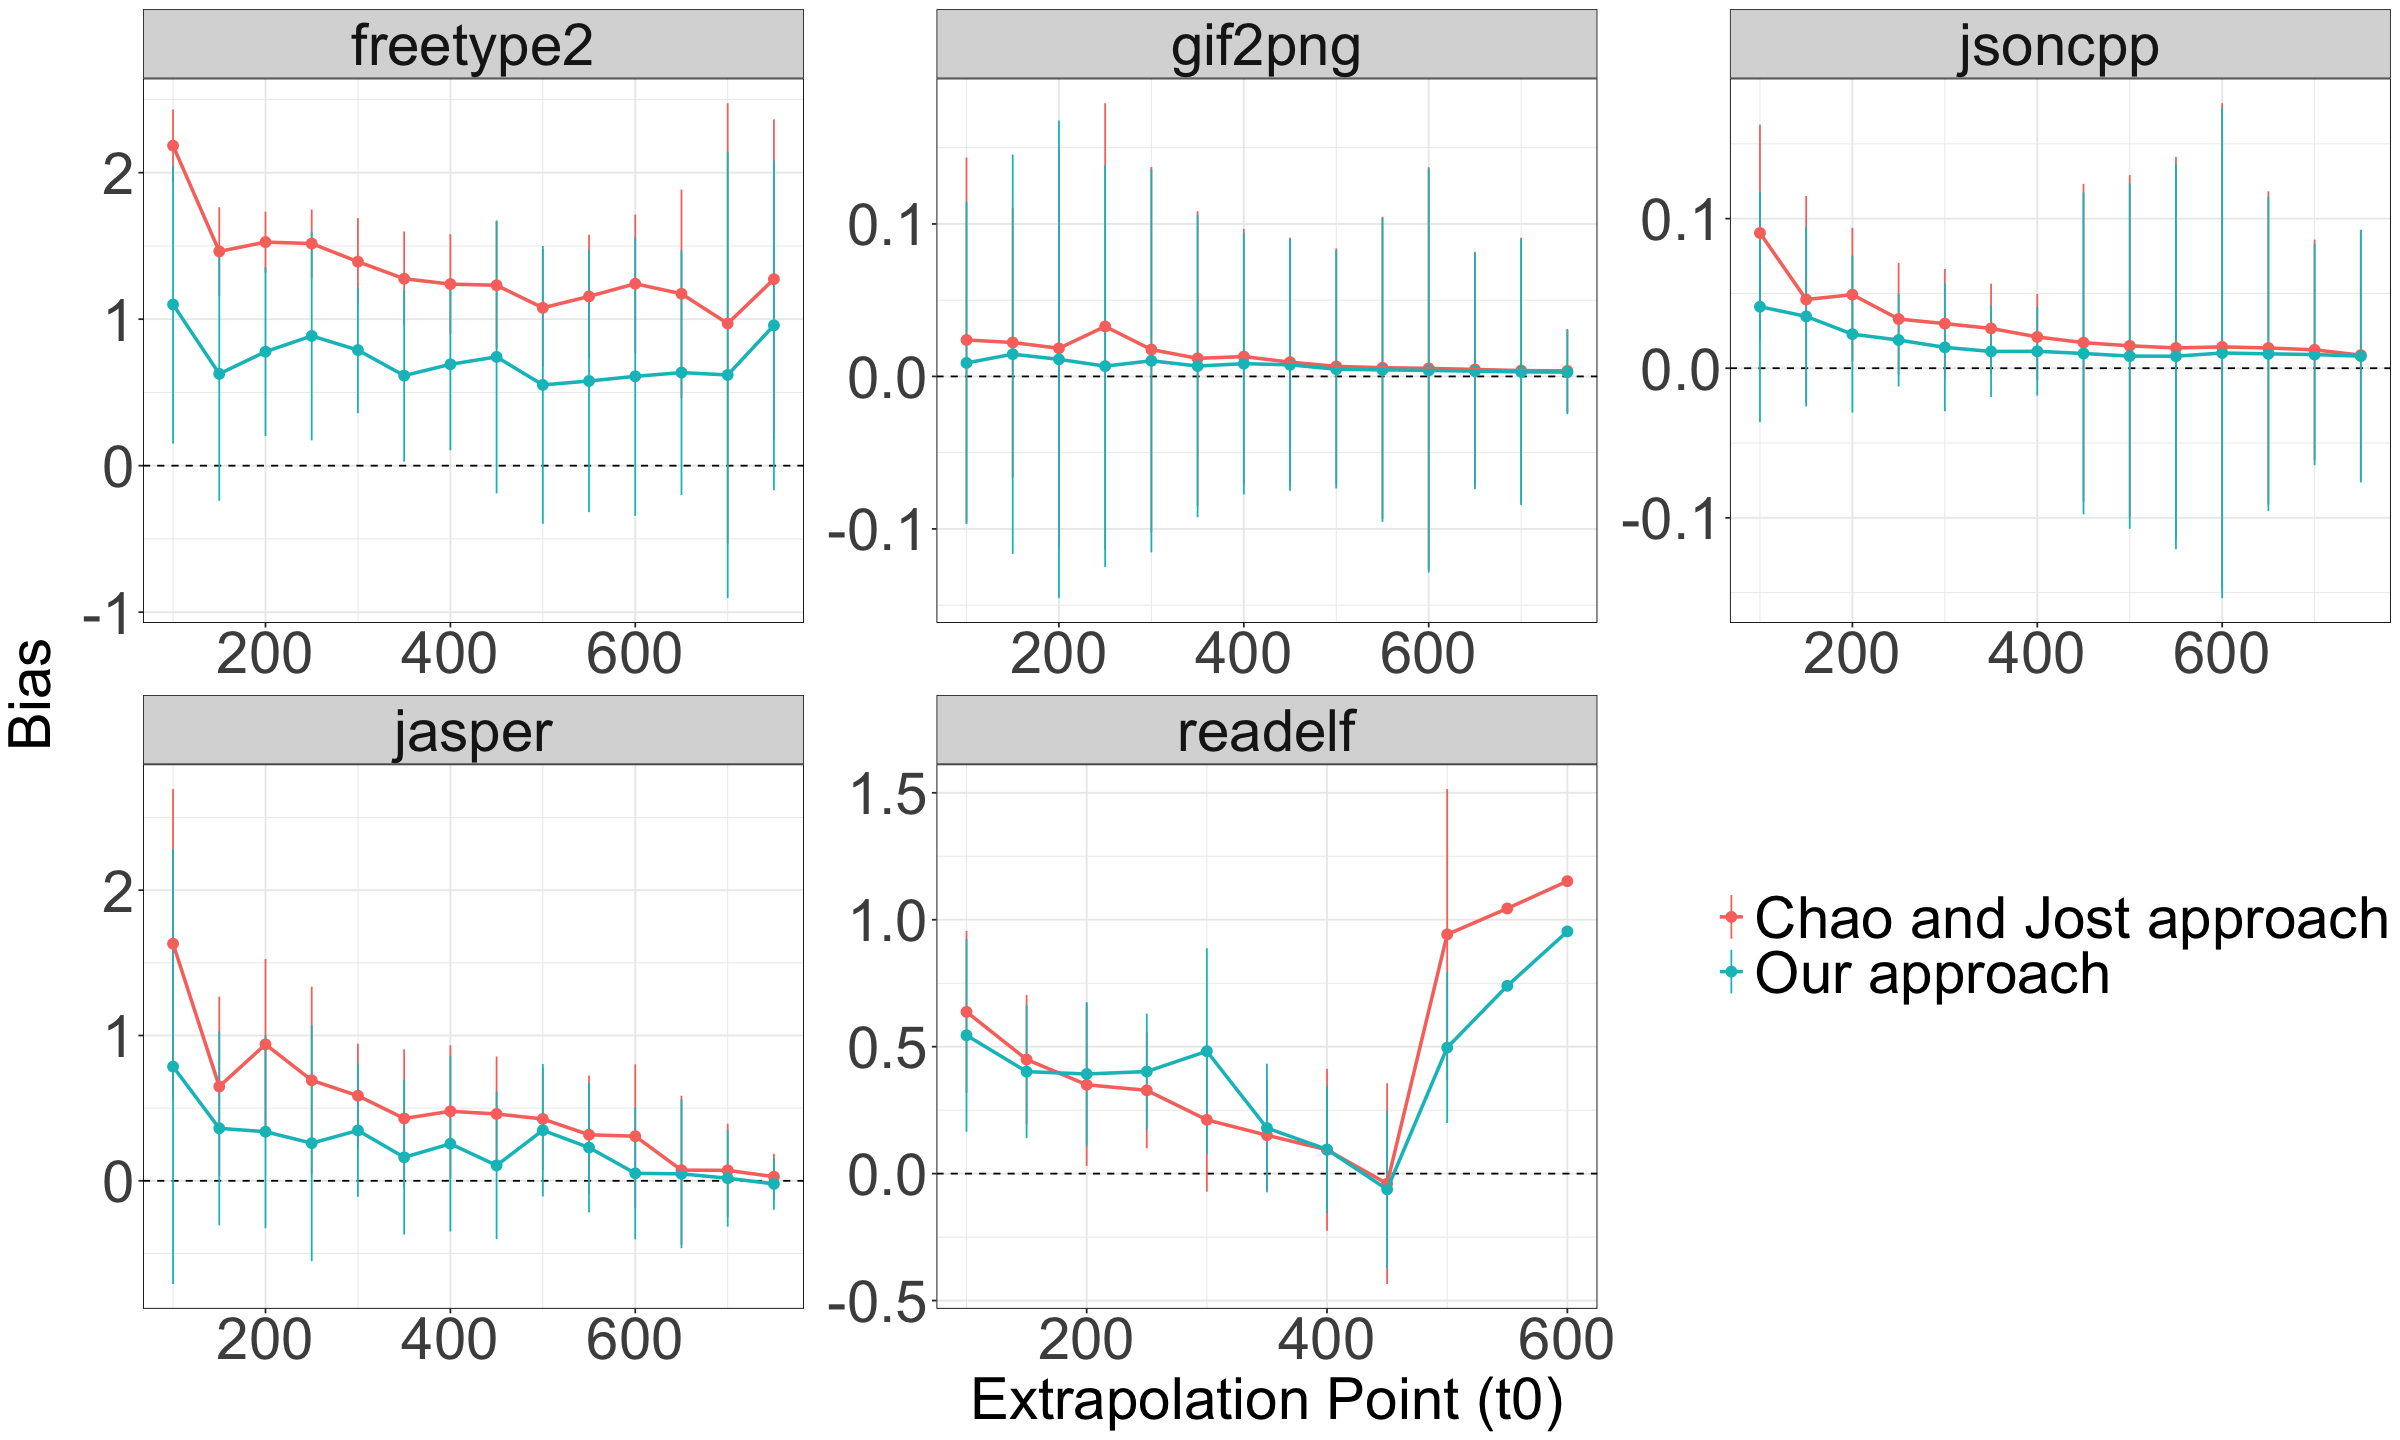

In [82]:
options(repr.plot.width = 20, repr.plot.height = 12)

p3 <- fit_df %>%
    filter(method == "deviation_existing" | method == "deviation_new") %>%
    mutate(method = ifelse(method == "deviation_existing", "Chao and Jost approach", "Our approach")) %>%
    group_by(subject, theta0, method) %>%
    summarise(median_fit = median(value), std = sd(value, na.rm = TRUE), .groups = "drop") %>%
    ungroup() %>%
    ggplot() +
    geom_hline(yintercept = 0, linetype = "dashed") +
    geom_point(aes(theta0, median_fit, color = method), size = 1.5) +
    geom_pointrange(aes(theta0, median_fit, ymin = median_fit - std, ymax = median_fit + std, color = method), width = 0.2) +
    geom_line(aes(theta0, median_fit, color = method), size = 1) +
    theme_bw() +
    theme(
        panel.border = element_rect(color = "black"),
        # panel.grid.major = element_blank(),
        # panel.grid.minor = element_blank(),
        axis.text.x = element_text(size = 35),
        strip.text.x = element_text(size = 35),
        axis.title.x = element_text(size = 35),
        axis.text.y = element_text(size = 35),
        axis.title.y = element_text(size = 35),
        legend.text = element_text(size = 35),
        legend.title = element_blank(),
        legend.position = c(0.85, 0.3)
    ) +
    scale_y_continuous("Bias") +
    scale_x_continuous("Extrapolation Point (t0)") +
    facet_wrap(~subject, scales = "free", ncol = 3)

g <- grid.arrange(p3, nrow = 1)
ggsave("figures/Figure-7.pdf", g, width = 20, height = 12)


In [ ]:
bias_result_prop %>%
    filter(method=="bias_existing" | method=="bias_new") %>%
    mutate(method=ifelse(method=="bias_existing","Chao and Jost approach","Our approach")) %>%
    mutate(theta0=as.factor(theta0*(1/4))) %>%
    group_by(subject,theta0,method) %>%
    summarise(m = 10^median(value)) %>%
    ungroup() %>%
    group_by(subject,method) %>%
    summarise(mx = max(m),mn = min(m)) %>%
    ungroup()

bias_result_prop %>%
    filter(method=="bias_existing" | method=="bias_new") %>%
    mutate(method=ifelse(method=="bias_existing","Chao and Jost approach","Our approach")) %>%
    filter(theta0 >= 300) %>%
    mutate(theta0=as.factor(theta0*(1/4))) %>%
    group_by(subject,theta0,method) %>%
    summarise(m = 10^median(value)) %>%
    ungroup() %>%
    group_by(subject,method) %>%
    summarise(mx = max(m),mn = min(m)) %>%
    ungroup()

`summarise()` has grouped output by 'subject', 'theta0'. You can override using
the `.groups` argument.
`summarise()` has grouped output by 'subject'. You can override using the
`.groups` argument.


subject   method                 mx           mn         
1  freetype2 Chao and Jost approach  0.361089154 0.013405075
2  freetype2 Our approach           39.350737058 1.492533618
3  gif2png   Chao and Jost approach  0.027702029 0.008370882
4  gif2png   Our approach           42.823162987 0.026926402
5  jsoncpp   Chao and Jost approach  0.005477747 0.001952367
6  jsoncpp   Our approach            8.041426856 0.031760645
7  jasper    Chao and Jost approach  0.013105321 0.002983736
8  jasper    Our approach            4.252156589 0.326123271
9  readelf   Chao and Jost approach  6.770085433 2.940841549
10 readelf   Our approach            2.508968256 0.807252057

`summarise()` has grouped output by 'subject', 'theta0'. You can override using
the `.groups` argument.
`summarise()` has grouped output by 'subject'. You can override using the
`.groups` argument.


subject   method                 mx          mn         
1  freetype2 Chao and Jost approach 0.074487317 0.013405075
2  freetype2 Our approach           4.317430434 1.492533618
3  gif2png   Chao and Jost approach 0.014227791 0.008370882
4  gif2png   Our approach           0.114183538 0.026926402
5  jsoncpp   Chao and Jost approach 0.005477747 0.001952367
6  jsoncpp   Our approach           0.111420404 0.031760645
7  jasper    Chao and Jost approach 0.013105321 0.002983736
8  jasper    Our approach           1.826689006 0.383358801
9  readelf   Chao and Jost approach 4.419522477 2.940841549
10 readelf   Our approach           2.508968256 1.435123895

In [ ]:
bias_result_prop %>%
    filter(method=="bias_existing" | method=="bias_new") %>%
    mutate(method=ifelse(method=="bias_existing","Chao and Jost approach","Our approach")) %>%
    mutate(theta0=as.factor(theta0*(1/4))) %>%
    group_by(subject,method) %>%
    summarise(m = max(10^median(value)))

bias_result_prop %>%
    filter(method=="bias_existing" | method=="bias_new") %>%
    mutate(method=ifelse(method=="bias_existing","Chao and Jost approach","Our approach")) %>%
    mutate(theta0=as.factor(theta0*(1/4))) %>%
    group_by(subject,method) %>%
    summarise(m = min(10^median(value)))

bias_result_prop %>%
    filter(method=="bias_existing" | method=="bias_new") %>%
    mutate(method=ifelse(method=="bias_existing","Chao and Jost approach","Our approach")) %>%
    filter(theta0 >= 300) %>%
    mutate(theta0=as.factor(theta0*(1/4))) %>%
    group_by(subject,method) %>%
    summarise(m = 10^median(value))

`summarise()` has grouped output by 'subject'. You can override using the
`.groups` argument.


subject   method                 m          
1  freetype2 Chao and Jost approach 0.065745796
2  freetype2 Our approach           4.125887779
3  gif2png   Chao and Jost approach 0.013313191
4  gif2png   Our approach           0.144824006
5  jsoncpp   Chao and Jost approach 0.002926438
6  jsoncpp   Our approach           0.148078434
7  jasper    Chao and Jost approach 0.006317888
8  jasper    Our approach           1.082305152
9  readelf   Chao and Jost approach 4.017952882
10 readelf   Our approach           1.574224943

`summarise()` has grouped output by 'subject'. You can override using the
`.groups` argument.


subject   method                 m          
1  freetype2 Chao and Jost approach 0.065745796
2  freetype2 Our approach           4.125887779
3  gif2png   Chao and Jost approach 0.013313191
4  gif2png   Our approach           0.144824006
5  jsoncpp   Chao and Jost approach 0.002926438
6  jsoncpp   Our approach           0.148078434
7  jasper    Chao and Jost approach 0.006317888
8  jasper    Our approach           1.082305152
9  readelf   Chao and Jost approach 4.017952882
10 readelf   Our approach           1.574224943

`summarise()` has grouped output by 'subject'. You can override using the
`.groups` argument.


subject   method                 m          
1  freetype2 Chao and Jost approach 0.030762093
2  freetype2 Our approach           2.744858104
3  gif2png   Chao and Jost approach 0.010696175
4  gif2png   Our approach           0.041137520
5  jsoncpp   Chao and Jost approach 0.003606095
6  jsoncpp   Our approach           0.061305830
7  jasper    Chao and Jost approach 0.006456349
8  jasper    Our approach           1.157527783
9  readelf   Chao and Jost approach 3.465164138
10 readelf   Our approach           2.119715108

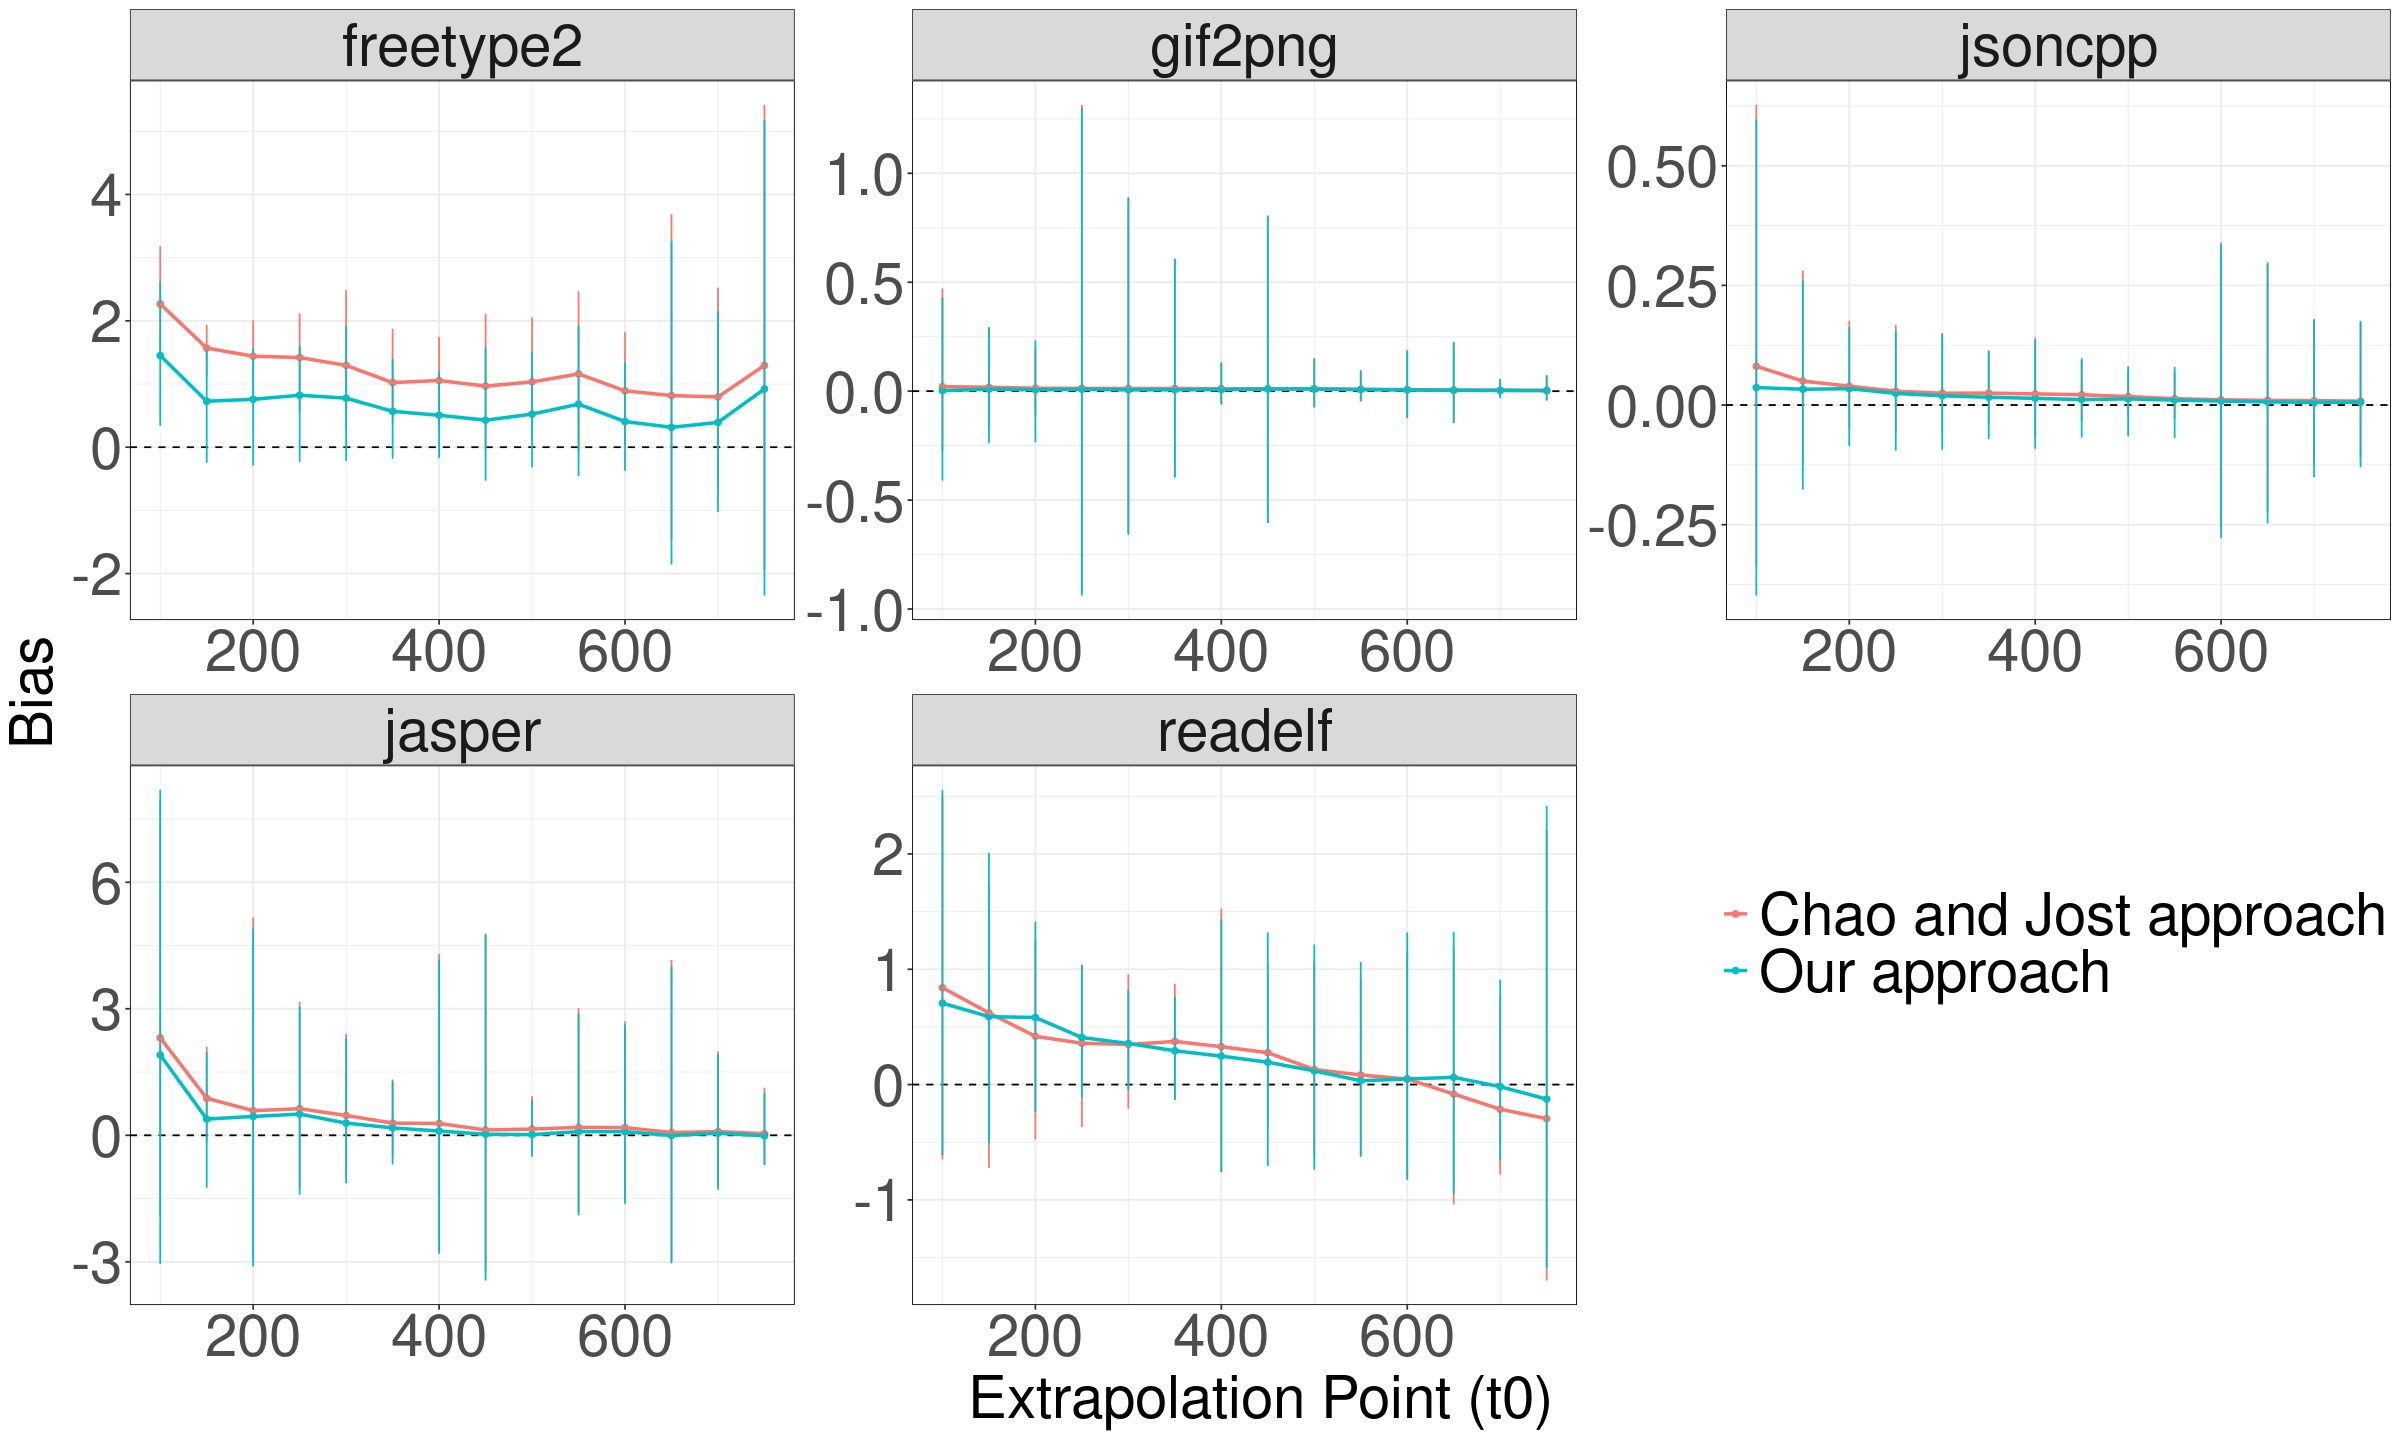

In [ ]:
options(repr.plot.width = 20, repr.plot.height = 12)

p3 = fit_df %>% merge(CI_df,by=c("subject","theta0","method"),all.x=TRUE) %>%
    filter(method == "deviation_existing" | method == "deviation_new") %>%
    mutate(method = ifelse(method == "deviation_existing", "Chao and Jost approach", "Our approach")) %>%
    group_by(subject,theta0,method) %>%
    #summarise(median_fit = median(value), lower = lower, upper = upper,std = sd(value,na.rm=TRUE), .groups="drop") %>%
    summarise(median_fit = median(value), mean_fit = mean(value), std = sd(value), .groups="drop") %>%
    ungroup() %>%
    ggplot() +
    geom_hline(yintercept=0, linetype="dashed") +
    geom_point(aes(theta0,median_fit,color = method),size = 1.5) +
    geom_errorbar(aes(theta0,median_fit,ymin = mean_fit-1.96*std, ymax = mean_fit+1.96*std,color = method), width = 0.2) + 
    geom_line(aes(theta0,median_fit,color = method),size = 1) +
    theme_bw() +
    theme(panel.border = element_rect(color = "black"), 
          #panel.grid.major = element_blank(), 
          #panel.grid.minor = element_blank(),
          axis.text.x = element_text(size = 35),
          strip.text.x = element_text(size = 35),
          axis.title.x = element_text(size = 35),
          axis.text.y = element_text(size = 35),
          axis.title.y = element_text(size = 35),
          legend.text = element_text(size = 35),
          legend.title = element_blank(),
          legend.position = c(0.85,0.3)) +
    scale_y_continuous("Bias") +
    scale_x_continuous("Extrapolation Point (t0)") +
    facet_wrap(~ subject, scales = "free", ncol = 3)

g = grid.arrange(p3, nrow = 1)
ggsave("figures/Figure-7.pdf",g,width=20,height=12)

In [ ]:
head(fit_df %>% 
    filter(method == "deviation_existing" | method == "deviation_new") %>%
    mutate(method = ifelse(method == "deviation_existing", "Chao and Jost approach", "Our approach")) %>%
    group_by(subject,theta0,method) %>%
    summarise(median_fit = median(value), .groups="drop") %>%
    ungroup())

subject   theta0 method                 median_fit
1 freetype2 100    Chao and Jost approach  2.4149410
2 freetype2 100    Our approach            1.1228760
3 freetype2 150    Chao and Jost approach  1.4418045
4 freetype2 150    Our approach            0.1139943
5 freetype2 200    Chao and Jost approach  1.5474777
6 freetype2 200    Our approach           -0.1764277

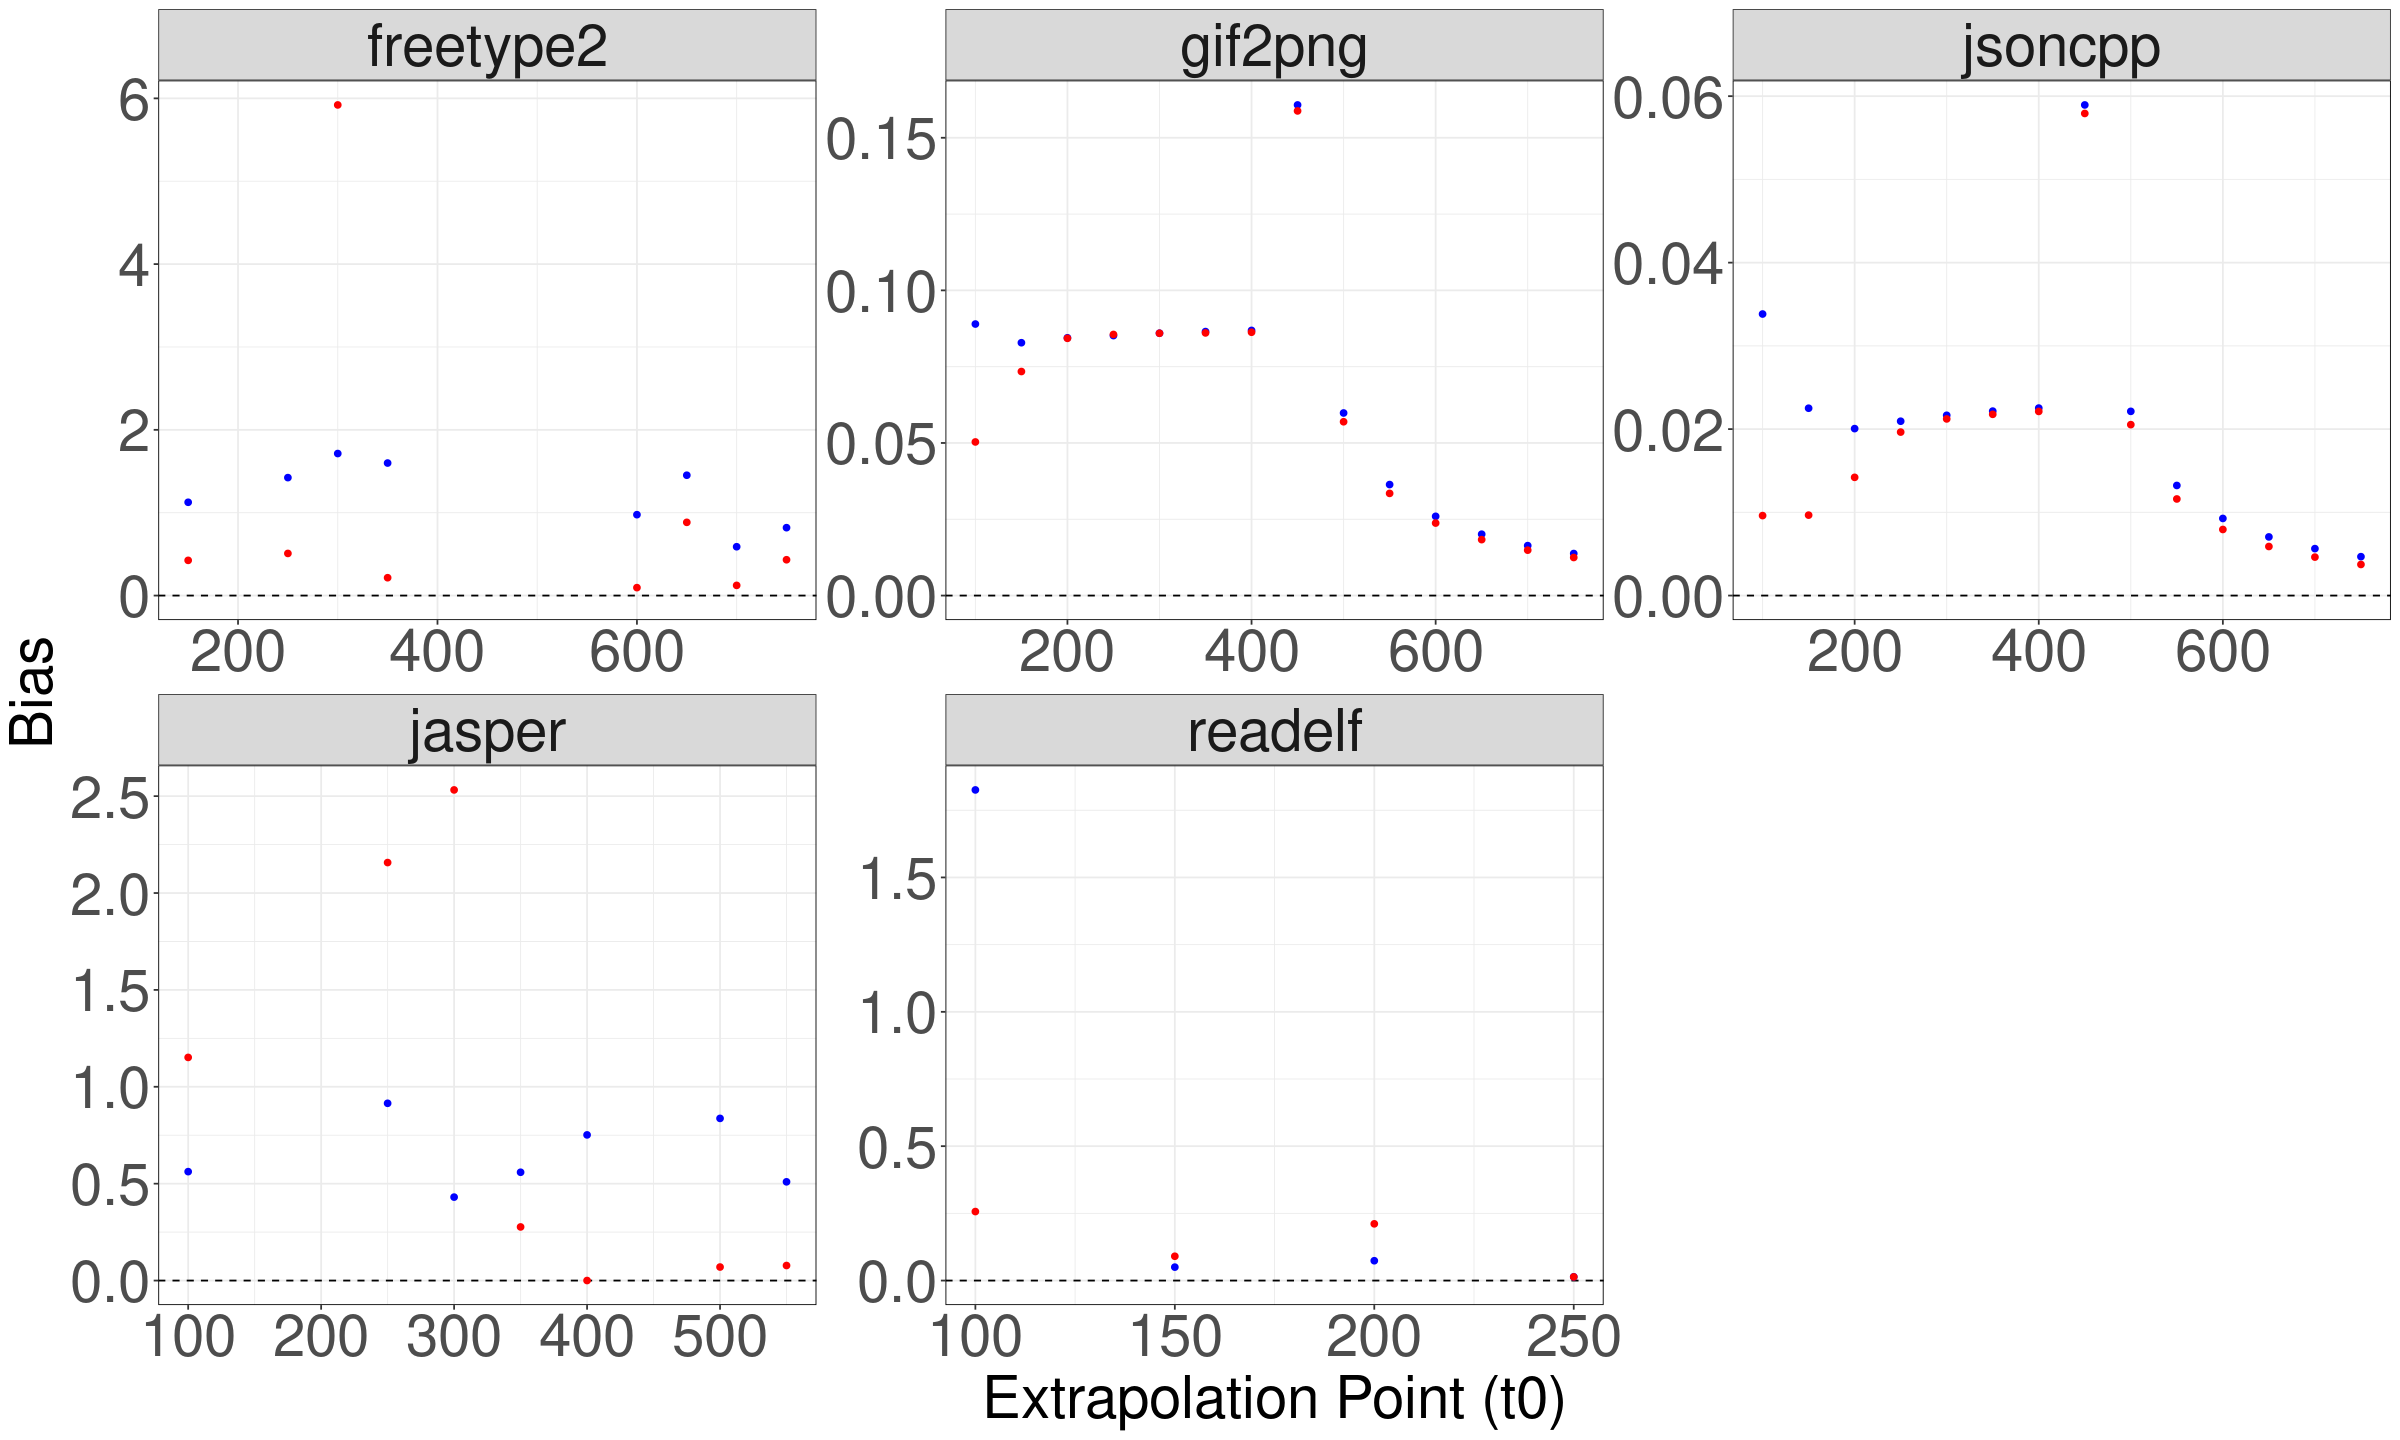

In [ ]:
#install.packages("effsize")
library(effsize)

fit_df %>%
    group_by(subject,run,theta0,threshold,method) %>%
    summarise(median_fit = median(value), .groups="drop") %>%
    ungroup() %>%
    pivot_wider(names_from = method, values_from = median_fit) %>%
    rename(Bias_Chao_Jost = deviation_existing, Bias_our = deviation_new) %>%
    mutate(abs_difference = abs(Bias_Chao_Jost - Bias_our)) %>%
    mutate(abs_chao = abs(Bias_Chao_Jost),abs_our = abs(Bias_our)) %>%
    #wilcox_effsize(value ~ method,alternate=ALTERNATE,paired=TRUE,conf.level=0.95) %>%
    group_by(subject,theta0) %>%
    summarise(mean_abs_diff = mean(abs_difference),std = sd(abs_difference),
              eff_size = VD.A(abs(Bias_Chao_Jost),abs(Bias_our))$estimate, 
              mean_abs_ex = mean(abs_chao),mean_abs_our = mean(abs_our),.groups="drop") %>%
    ggplot() +
    geom_hline(yintercept=0, linetype="dashed") +
    #geom_point(aes(theta0,mean_abs_diff),size = 1.5) +
    geom_point(aes(theta0,mean_abs_ex),size = 1.5,color="blue") +
    geom_point(aes(theta0,mean_abs_our),size = 1.5,color="red") +
    #geom_pointrange(aes(theta0,mean_abs_diff,ymin = mean_abs_diff-1.96*std, ymax = mean_abs_diff+1.96*std), width = 0.2) + 
    #geom_line(aes(theta0,mean_abs_diff),size = 1) +
    theme_bw() +
    theme(panel.border = element_rect(color = "black"), 
          #panel.grid.major = element_blank(), 
          #panel.grid.minor = element_blank(),
          axis.text.x = element_text(size = 35),
          strip.text.x = element_text(size = 35),
          axis.title.x = element_text(size = 35),
          axis.text.y = element_text(size = 35),
          axis.title.y = element_text(size = 35),
          legend.text = element_text(size = 35),
          legend.title = element_blank(),
          legend.position = c(0.85,0.3)) +
    scale_y_continuous("Bias") +
    scale_x_continuous("Extrapolation Point (t0)")  +
    facet_wrap(~ subject, scales = "free", ncol = 3)

In [ ]:
fit_df %>%
    group_by(subject,run,theta0,threshold,method) %>%
    summarise(median_fit = median(value), .groups="drop") %>%
    ungroup() %>%
    pivot_wider(names_from = method, values_from = median_fit) %>%
    rename(Bias_Chao_Jost = deviation_existing, Bias_our = deviation_new) %>%
    mutate(abs_difference = abs(Bias_Chao_Jost - Bias_our)) %>%
    mutate(abs_chao = abs(Bias_Chao_Jost),abs_our = abs(Bias_our)) %>%
    #wilcox_effsize(value ~ method,alternate=ALTERNATE,paired=TRUE,conf.level=0.95) %>%
    group_by(subject,threshold) %>%
    summarise(mean_abs_ex = mean(abs_chao)/threshold,mean_abs_our = mean(abs_our)/threshold,.groups="drop") %>%
    ungroup() %>%
    distinct()

subject   threshold  mean_abs_ex mean_abs_our
1 freetype2 0.51851852 2.312688    1.732293    
2 gif2png   0.01244813 5.236338    5.214225    
3 jsoncpp   0.01739130 2.885311    2.433262    
4 jasper    0.11864407 5.613787    6.286062    
5 readelf   0.22222222 2.264417    2.896447

In [ ]:
VD.A(Bias_Chao_Jost,Bias_our)

subject   theta0 mean_abs_diff std          eff_size 
1  freetype2 100    3.3786189502  3.7120904286 0.6000000
2  freetype2 150    1.6582324620  0.7670502183 0.7031250
3  freetype2 200    1.5202685620  0.5703634026 0.8400000
4  freetype2 250    1.3591996846  0.5367142673 0.7955556
5  freetype2 300    1.4241670740  0.7087458154 0.9350000
6  freetype2 350    1.1600855815  0.4132018072 0.9111570
7  freetype2 400    1.4656555174  1.3965816123 0.6643991
8  freetype2 450    1.4904461214  1.5426619542 0.6666667
9  freetype2 500    1.2012733663  0.8499380587 0.8320312
10 freetype2 550    0.9812322464  0.7359138288 0.7437642
11 freetype2 600    0.9687613676  0.9434388349 0.8107639
12 freetype2 650    0.6307581239  0.4255640248 0.7647929
13 freetype2 700    0.3973217038  0.2470705623 0.6168639
14 freetype2 750    0.3234713403  0.0619295532 0.6000000
15 gif2png   100    0.0337686997  0.0736786587 0.7091837
16 gif2png   150    0.0825104926  0.3095000773 0.6880165
17 gif2png   200    0.0570475760  0.1420444560 0.6560000
18 gif2png   250    0.0614307931  0.1641866050 0.6390533
19 gif2png   300    0.0081037366  0.0076820094 0.6117970
20 gif2png   350    0.0051725999  0.0043788070 0.6052319
21 gif2png   400    0.0036720709  0.0039714233 0.5766667
22 gif2png   450    0.0025703373  0.0027903557 0.5666667
23 gif2png   500    0.0019808258  0.0022829092 0.5544444
24 gif2png   550    0.0015868301  0.0019823905 0.5622222
25 gif2png   600    0.0013173770  0.0018596310 0.5566667
26 gif2png   650    0.0010906387  0.0013704043 0.5511111
27 gif2png   700    0.0009382773  0.0005886414 0.5600000
28 gif2png   750    0.0010410558  0.0009436566 0.5675000
29 jsoncpp   100    0.0575158985  0.0580684573 0.6747405
30 jsoncpp   150    0.0384550877  0.0815392521 0.6462585
⋮  ⋮         ⋮      ⋮             ⋮            ⋮        
38 jsoncpp   550    0.004214318   0.005125977  0.6145833
39 jsoncpp   600    0.003432588   0.004193976  0.5992439
40 jsoncpp   650    0.002956820   0.003289367  0.5784499
41 jsoncpp   700    0.002662255   0.003447158  0.5746692
42 jsoncpp   750    0.002155053   0.003506845  0.5937500
43 jasper    100    3.063990864   6.791961817  0.6035503
44 jasper    150    0.915179135   1.004057577  0.7933884
45 jasper    200    1.623862806   2.697441961  0.6712803
46 jasper    250    1.128118067   1.557536679  0.7006173
47 jasper    300    0.612962509   0.597574322  0.7650000
48 jasper    350    0.488982924   0.748317534  0.6952909
49 jasper    400    0.373603255   0.484931658  0.7577855
50 jasper    450    0.932457429   2.248983334  0.7500000
51 jasper    500    0.096004993   0.101629775  0.6800000
52 jasper    550    0.095457759   0.097865011  0.6577778
53 jasper    600    0.180038541   0.369996434  0.6332180
54 jasper    650    0.121619937   0.259120810  0.6124567
55 jasper    700    0.058454082   0.032608241  0.6530612
56 jasper    750    0.055391538   0.031625260  0.7688889
57 readelf   100    0.803729216   0.996200668  0.5293006
58 readelf   150    0.926323091   0.830205318  0.5211111
59 readelf   200    0.533704553   0.585936006  0.5101070
60 readelf   250    0.473247736   0.432508697  0.5458580
61 readelf   300    1.075551150   0.998028513  0.3378685
62 readelf   350    0.354018586   0.486488171  0.3979239
63 readelf   400    0.420073696   0.788496527  0.3775510
64 readelf   450    0.320402875   0.378905019  0.4320988
65 readelf   500    0.929625295   0.237730499  1.0000000
66 readelf   550    1.356410164            NA  1.0000000
67 readelf   600    2.561926291            NA  1.0000000

In [142]:
CI_df = fit_df %>%
    group_by(subject,theta0,method) %>%
    summarise(median_fit = median(value),mean_fit = mean(value),std = sd(value),
              upper = quantile(value,0.75), .groups="drop") %>%
    ungroup()

#lower = quantile(value,0.25),
#              upper = quantile(value,0.75), .groups="drop") %>%

head(CI_df %>% filter(subject=="freetype2",theta0==200,method=="deviation_new"))

subject   theta0 method        median_fit mean_fit  std      upper    
1 freetype2 200    deviation_new -0.1764277 0.2647942 1.013967 0.1881933

In [108]:
fit_df %>% merge(CI_df,by=c("subject","theta0","method"),all.x=TRUE) %>%
mutate(within = ifelse(value>=lower & value <= upper,1,0)) %>%
group_by(subject,method,threshold) %>%
summarise(prop = sum(within)/n()) %>%
ungroup() %>%
group_by(subject,method) %>%
summarise(avg_prop = mean(prop)) %>%
ungroup()


`summarise()` has grouped output by 'subject', 'method'. You can override using
the `.groups` argument.
`summarise()` has grouped output by 'subject'. You can override using the
`.groups` argument.


subject   method             avg_prop 
1  freetype2 deviation_existing 0.7644628
2  freetype2 deviation_new      0.3553719
3  gif2png   deviation_existing 0.7851240
4  gif2png   deviation_new      0.6584022
5  jsoncpp   deviation_existing 0.7483444
6  jsoncpp   deviation_new      0.6390728
7  jasper    deviation_existing 0.7232143
8  jasper    deviation_new      0.3616071
9  readelf   deviation_existing 0.4914286
10 readelf   deviation_new      0.4685714

In [73]:
fit_df %>%
group_by(subject,threshold,method) %>%
summarise(mab = mean(abs(value)))

`summarise()` has grouped output by 'subject', 'threshold'. You can override
using the `.groups` argument.


subject   threshold  method             mab       
1  freetype2 0.51851852 deviation_existing 1.19917146
2  freetype2 0.51851852 deviation_new      0.89822608
3  gif2png   0.01244813 deviation_existing 0.06518263
4  gif2png   0.01244813 deviation_new      0.06490736
5  jsoncpp   0.01739130 deviation_existing 0.05017933
6  jsoncpp   0.01739130 deviation_new      0.04231760
7  jasper    0.11864407 deviation_existing 0.66604250
8  jasper    0.11864407 deviation_new      0.74580397
9  readelf   0.22222222 deviation_existing 0.50320379
10 readelf   0.22222222 deviation_new      0.64365500

In [ ]:
fit_df %>%
group_by(subject,threshold,method) %>%
summarise(mab = mean(abs(value)))

In [ ]:
type_df = tibble()

for(i in 1:length(subjects)){
    threshold = thresholds[i]
    selected_sub = subjects[i]
    
    fit_df = tibble()
    
    df1 = prediction_fit %>%
        filter(subject==selected_sub) %>%
        mutate(threshold = threshold, passed_cutoff = ifelse(threshold>delta_new,1,0)) %>%
        group_by(subject,run,theta0,threshold) %>%
        mutate(all_below_new = all(passed_cutoff==1),all_above_new = all(passed_cutoff==0)) %>%
        summarise(all_below_new = max(all_below_new),all_above_new = max(all_above_new), .groups="drop") %>%
        ungroup()

    df2 = prediction_fit %>%
            filter(subject==selected_sub) %>%
            mutate(threshold = threshold, passed_cutoff = ifelse(threshold>delta_existing,1,0)) %>%
            group_by(subject,run,theta0,threshold) %>%
            mutate(all_below_existing = all(passed_cutoff==1),all_above_existing = all(passed_cutoff==0)) %>%
            summarise(all_below_existing = max(all_below_existing),all_above_existing = max(all_above_existing), .groups="drop") %>%
            ungroup()
        
        combined = merge(df1,df2,by=c("subject","run","theta0","threshold"))
        fit_df = rbind(fit_df,combined)
    
    fit_df = fit_df %>% 
                select(subject,run,theta0,threshold,all_below_new,all_below_existing,
                        all_above_new,all_above_existing)
    
    fit_df = fit_df %>%
        group_by(subject,run,theta0,threshold) %>%
        mutate(cnt1 = ifelse((all_below_new==1 & all_below_existing == 1 & all_above_new ==1 & all_above_existing==1),1,0),
               cnt2 = ifelse((all_below_new==1 & all_below_existing == 1 & all_above_new ==0 & all_above_existing==1),1,0),
               cnt3 = ifelse((all_below_new==1 & all_below_existing == 0 & all_above_new ==1 & all_above_existing==1),1,0),
               cnt4 = ifelse((all_below_new==1 & all_below_existing == 0 & all_above_new ==0 & all_above_existing==1),1,0),
               cnt5 = ifelse((all_below_new==0 & all_below_existing == 1 & all_above_new ==1 & all_above_existing==1),1,0),
               cnt6 = ifelse((all_below_new==0 & all_below_existing == 1 & all_above_new ==0 & all_above_existing==1),1,0),
               cnt7 = ifelse((all_below_new==0 & all_below_existing == 0 & all_above_new ==1 & all_above_existing==1),1,0),
               cnt8 = ifelse((all_below_new==0 & all_below_existing == 0 & all_above_new ==0 & all_above_existing==1),1,0),
               cnt9 = ifelse((all_below_new==1 & all_below_existing == 1 & all_above_new ==1 & all_above_existing==0),1,0),
               cnt10 = ifelse((all_below_new==1 & all_below_existing == 1 & all_above_new ==0 & all_above_existing==0),1,0),
               cnt11 = ifelse((all_below_new==1 & all_below_existing == 0 & all_above_new ==1 & all_above_existing==0),1,0),
               cnt12 = ifelse((all_below_new==1 & all_below_existing == 0 & all_above_new ==0 & all_above_existing==0),1,0),
               cnt13 = ifelse((all_below_new==0 & all_below_existing == 1 & all_above_new ==1 & all_above_existing==0),1,0),
               cnt14 = ifelse((all_below_new==0 & all_below_existing == 1 & all_above_new ==0 & all_above_existing==0),1,0),
               cnt15 = ifelse((all_below_new==0 & all_below_existing == 0 & all_above_new ==1 & all_above_existing==0),1,0),
               cnt16 = ifelse((all_below_new==0 & all_below_existing == 0 & all_above_new ==0 & all_above_existing==0),1,0))%>%
        ungroup() %>%
        select(subject,run,theta0,threshold,cnt1,cnt2,cnt3,cnt4,cnt5,cnt6,cnt7,cnt8,cnt9,cnt10,
                  cnt11,cnt12,cnt13,cnt14,cnt15,cnt16) %>%
        distinct() %>%
        group_by(subject,theta0,threshold) %>%
        summarise(type_1 = sum(cnt10),type_2 = sum(cnt13)+sum(cnt15),
                  type_3 = sum(cnt14)+sum(cnt16)+sum(cnt12),type_4 = sum(cnt7), .groups="drop") %>%
        ungroup() %>%
        group_by(subject,threshold) %>%
        summarise(type_1 = ceiling(mean(type_1)),type_2 = ceiling(mean(type_2)),
                  type_3 = ceiling(mean(type_3)),type_4 = ceiling(mean(type_4)), .groups="drop") %>%
        ungroup()
     
    type_df = rbind(type_df,fit_df)
    
}

head(type_df)


### RQ 2 - Sensitivity Analysis

As we answer our RQ2 in the paper, we investigate the impact of the ***alpha*** and ***beta** parameters in our extrapolation algorithm. We choose one prediction point (t0=75hrs) and a single prediction horizon (m=1).

In [ ]:
if(REGENERATE_DATA){
    
    subjects = list.files("../data/fuzztastic_data/")
    
    RESET = TRUE
    sub1 = 1
    sub2 = 1
    n_reps = 1
    for(subject in subjects){
        folder = paste("../data/fuzztastic_data/",subject,"/","seed_01",sep="")
        for(file_run in list.files(folder)){
            data = tibble()
            subject = subject
            run = str_sub(file_run,-2)
            timestamps = c()
            n_list = c()
            sn_list = c()
            f1_list = c()
            f2_list = c()
            u_list = c()
            for(file in list.files(paste(folder,"/",file_run,sep=""))){
                ## Prepare the hit count table using all the available data
                bb_cov = as.data.frame(fromJSON(paste(folder,"/",file_run,"/",file,sep="")))
                bb_cov = bb_cov %>% mutate(block_coverage = ifelse(block_coverage>=8,block_coverage-8,block_coverage)) 
                temp = t(as.data.frame(bb_cov$block_coverage))
                colnames(temp) = 1:length(bb_cov$block_coverage)
                row.names(temp) = NULL
                temp = as.data.frame(temp)
                timestamps = c(timestamps,as.integer(substr(str_split(file,"_")[[1]][3],1,10)))
                n_list = c(n_list,max(bb_cov$block_coverage))
                sn_list = c(sn_list,sum((bb_cov$block_coverage)>0))
                data = rbind(data,temp)
            }
            bb_ids = 1:length(bb_cov$block_coverage)
            transformed = data %>% summarise(across(1:length(bb_ids),function(x) cumsum(c(0,ifelse(diff(x)>0,1,0)))))
            f1_list = apply(transformed,1,function(x) sum(as.numeric(unlist(x))==1))
            f2_list = apply(transformed,1,function(x) sum(as.numeric(unlist(x))==2))
            u_list = rowSums(transformed)
            gb_df = tibble(subject=subject,run=run,timestamp=timestamps,n=n_list,theta=0:length(n_list[-1]),
                           u=u_list,f1=f1_list,f2=f2_list,sn_gb=sn_list)
            ## Write gb_data
            if(sub1==1){
               write.table(gb_df, file = "../data/gb_data_sensitivity.csv", row.names = FALSE,quote = FALSE)  
               sub1 = sub1 + 1
            }else{
               write.table(gb_df, file = "../data/gb_data_sensitivity.csv",
                append = TRUE, quote = FALSE,
                col.names = FALSE, row.names = FALSE)
            }
            
            transformed = data %>% summarise(across(1:length(bb_ids),function(x) ifelse(diff(x)>0,1,0)))
            timestamps = timestamps[-1]
            n_list = n_list[-1]
            u_list = u_list[-1]
            sn_list = sn_list[-1]
            f1_list = f1_list[-1]
            f2_list = f2_list[-1]
            
            alpha_list = c(1,0.7,0.5,0.3)
            for(rep in 1:n_reps){
                for(m in seq(1,length(u_list),4)){
                    dis_prob = tibble()
                    cores = 8 #detectCores()
                    cl = makeCluster(cores[1]-1,type = "FORK")
                    registerDoParallel(cl)
                    ## Shuffling algorithm (difference, shuffle, reconstitute) for selected theta0
                    ## Do the estimates for all X = theta0-k where 0<k<theta0 after the shuffling algorithm
                    ## To get more estimates, repeat this several times (i.e. # of repetitions)
                    dis_prob = foreach(alp=alpha_list, .combine='rbind', .packages=c("dplyr", "tidyverse")) %dopar% {
                       filtered = transformed %>% mutate(theta=1:n()) %>% filter(theta<=m)
                       if(RESET){
                           cut_pt = round(exp(seq(log(1),log(m),length=11))[(10*(1-alp)+1)])
                           filtered = filtered %>% filter(theta>=cut_pt)
                       }else{
                           cut_pt = 0
                       }
                       theta_list = filtered$theta
                       filtered = filtered %>% select(-theta)
                       shuffle_order = sample(1:nrow(filtered),nrow(filtered))
                       filtered = filtered[shuffle_order,]
                       filtered = filtered %>% summarise(across(1:length(bb_ids),cumsum))
                       f1 = apply(filtered,1,function(x) sum(as.numeric(unlist(x))==1))
                       f2 = apply(filtered,1,function(x) sum(as.numeric(unlist(x))==2))
                       sn = apply(filtered,1,function(x) sum(as.numeric(unlist(x))>0))
                       rm(list = c("filtered"))
                       tibble(subject=subject,alpha=alp,run=run,repetition=rep,timestamp=timestamps[m],
                              time=timestamps[cut_pt:m],n0=n_list[m],n=n_list[cut_pt:m],theta=theta_list,
                              start=cut_pt,theta0=m,f1=f1+1,f2=f2+1,
                              gt=(f1/(theta-start))*(((theta-start-1)*f1)/((theta-start-1)*f1+(2*f2))),
                              sn=sn,s=length(bb_ids))
                    }
                    
                    if(sub2==1){
                        write.table(dis_prob, file = "../data/bb_data_sensitivity.csv", row.names = FALSE,
                                    quote = FALSE)
                        sub2 = sub2 + 1
                    }else{
                        write.table(dis_prob, file = "../data/bb_data_sensitivity.csv",
                        append = TRUE, quote = FALSE,
                        col.names = FALSE, row.names = FALSE)
                    }
                    stopCluster(cl)
                    gc()
                }
            }
        }
    }
    ## Save gathered data as R objects for future use
    gb_data = read.table("../data/gb_data_sensitivity.csv",header=T)
    gb_data$run = as.factor(gb_data$run)
    
    gb_data = gb_data %>% 
                rename(f1_gb=f1,f2_gb=f2) %>%
                mutate(f1_gb = f1_gb + 1,f2_gb = f2_gb + 1)
    save(gb_data,file="../data/gb_data_sensitivity.Rdata")
    
    bb_data = read.table("../data/bb_data_sensitivity.csv",header=T)
    # Remove infinite values from extrapolated data table
    bb_data = bb_data %>% filter_all(all_vars(!is.infinite(.)))
    bb_data$run = as.factor(bb_data$run)
    
    # Attach greybox data to shuffling data
    bb_data = merge(bb_data,gb_data %>% select(subject,run,timestamp,f1_gb,f2_gb,sn_gb),
                    by=c("subject","run","timestamp"),all.x = TRUE)
    save(bb_data,file="../data/bb_data_sensitivity.Rdata")
} else{
    ## Loading saved data
    load(file="../data/gb_data_sensitivity.Rdata")
    load(file="../data/bb_data_sensitivity.Rdata")
}                       


In [ ]:
## Perform Extrapolation
if(REGENERATE_DATA){
    # Initialize parameter ranges
    init = 1
    train_data = tibble()
    t0_list = 300
    subjects = unique(gb_data$subject)
    proportions = c(0.5,0.75,1,1.5,2,3)
    gamma_list = c(1,0.7,0.5,0.3,0.1)
    for(sub in subjects){
        for(trial in unique(bb_data$run)){
            for(gam in gamma_list){
                for(alp in unique(bb_data$alpha)){
                    # Filter required data
                    bb_df = bb_data %>% filter(run==trial) %>% 
                            filter(subject==sub) %>% filter(alpha==alp) %>% filter((theta-start)>=5)
                    gb_df = gb_data %>% filter(run==trial) %>% filter(subject==sub)
                    for(t0 in t0_list){
                        
                        ######################################
                        reg_df = bb_df %>% filter(theta0<=t0)
                        
                        tryCatch({
                        # Only to get most recent points as training
                        train_limit = exp(seq(log(min((reg_df %>% filter(theta>0))$theta)),
                                  log(max((reg_df %>% filter(theta>0))$theta0)),length=11))[(10*(1-gam)+1)]
                        reg_df = reg_df %>% arrange(theta) %>% filter(theta>=train_limit)
                
                        reg_df[is.na(reg_df) | reg_df == "Inf"] = NA
                        #reg_df = reg_df %>% mutate(gt=replace(gt,gt==0,NA))
                        reg_df = reg_df %>% drop_na()
                        model = lm(log(gt)~log(theta),data = reg_df)
                        slope = model$coefficient[2]
                        intercept = model$coefficient[1]
                        
                        ######################################
                        predict_df = (gb_df %>% arrange(theta) %>% filter(theta>=max(reg_df$theta)))
                        f1_gb = predict_df$f1_gb[1]
                        f2_gb = predict_df$f2_gb[1]
                        theta0 = predict_df$theta[1]
                        extra_df = tibble()
                        for(prop in proportions){
                            m = round(prop*t0)
                            if(nrow(predict_df)<m){
                            m = nrow(predict_df)
                            }
                            delta_new=as.numeric(lapply(1:m, function(x) exp((slope*log(theta0+x)+intercept))))
                                                        
                            extra_df = rbind(extra_df,
                                             tibble(subject=sub,alpha=alp,gamma=gam,run=trial,theta0=t0,prop=prop,
                                                    theta=seq(max(reg_df$theta),length=m),
                                                    delta_new=delta_new,sn_gb=predict_df$sn_gb[1:m]))
                                    
                        }
                                                 
                        if(init==1){
                           write.table(extra_df, file = "../data/extrapolated_sensitivity.csv", row.names = FALSE,
                                       quote = FALSE)
                           init = init + 1
                        }else{
                           write.table(extra_df, file = "../data/extrapolated_sensitivity.csv",
                           append = TRUE, quote = FALSE,
                           col.names = FALSE, row.names = FALSE)
                        }
                        
                        }, error=function(e){})
                    }
                }
            } 
        }
    }

    ## Save gathered data as R objects for future use
    extrapolated = read.table("../data/extrapolated_sensitivity.csv",header=T)
    save(extrapolated,file="../data/extrapolated_sensitivity.Rdata")
}else{
    ## Loading saved data
    load(file="../data/extrapolated_sensitivity.Rdata")
}

In [ ]:
# Moving average function to compute ground-truth
moving_average = function(x, n = 5) {
    ret = c()
    for (i in 1:length(x)) {
        min_idx = max(1, i - n + 1)
        max_idx = min(length(x), i + n - 1)
        if (sum(x[min_idx:i]) == 0) {
            # find closest non-zero value
            if (min_idx - 1 >= 1) {
                for (j in seq(min_idx - 1, 1, -1)) {
                    if (x[j] > 0) {
                        min_idx = j
                        break
                    }
                }
            }
        }
        if (sum(x[i:max_idx]) == 0) {
            # find closest non-zero value
            if (max_idx + 1 <= length(x)) {
                for (j in seq(max_idx + 1, length(x))) {
                    if (x[j] > 0) {
                        max_idx = j
                        break
                    }
                }
            }
        }
        ret = c(ret, mean(x[min_idx:max_idx]))
    }
    return (ret)
}

# Compute the ground-truth using smoothen species richness curve
gt_data = gb_data %>%
              group_by(subject,run) %>%
              mutate(smooth_gb = sn_gb) %>% #predict(loess(sn_gb ~ theta, span=0.05))
              ungroup()%>%
              group_by(subject,run,theta) %>%
              summarise(mean_sn=mean(smooth_gb),) %>%
              arrange(theta) %>%
              mutate(ground=c(NA,diff(mean_sn))) %>%
              mutate(ground_ma=c(NA,moving_average(diff(mean_sn)))) %>%
              ungroup()


In [ ]:
## Compute Mean Squared Error
mse_result = extrapolated %>%
            filter(theta0>=100) %>%
            merge(gt_data,by=c("subject","run","theta"),all.x=TRUE) %>%
            mutate(delta_new=log(delta_new),ground=log(ground_ma)) %>%
            group_by(subject,run,theta0,alpha,gamma,prop) %>%
            summarize(bias_new=mean(delta_new-ground), .groups = "drop") %>%
            ungroup()

mse_result = mse_result %>%
                group_by(subject,run,theta0,alpha,gamma,prop) %>%
                pivot_longer(!c(subject,run,theta0,alpha,gamma,prop),names_to = "method", values_to = "value") %>%
                ungroup()


mse_res = mse_result %>%
        filter(method=="bias_new") %>%
        arrange(theta0) %>%
        mutate(theta0 = theta0*(1/4)) %>% 
        rename(beta=gamma) %>%
        filter(prop==1) %>%
        group_by(subject,theta0,prop,alpha,beta) %>%
        summarize(value = median(value),.groups="drop") %>%
        ungroup()        

p1 = mse_res %>%
        filter(beta==0.5) %>%
        group_by(subject,theta0,prop,alpha) %>%
        summarize(value = median(value),.groups="drop") %>%
        ungroup() %>%
        group_by(subject,theta0,prop) %>%
        pivot_longer(!c(subject,theta0,prop,value),names_to = "parameter", values_to = "param_val")

p2 = mse_res %>%
        filter(alpha==0.3) %>%
        group_by(subject,theta0,prop,beta) %>%
        summarize(value = median(value),.groups="drop") %>%
        ungroup() %>%
        group_by(subject,theta0,prop) %>%
        pivot_longer(!c(subject,theta0,prop,value),names_to = "parameter", values_to = "param_val")

mse_res = rbind(p1,p2)

options(repr.plot.width = 20, repr.plot.height = 15)
pp = mse_res %>%
filter(theta0==75) %>%
  mutate(param_val = as.numeric(as.character(param_val)), theta0 = factor(theta0)) %>%
  ggplot(aes(x = param_val, y = value, color = theta0, group = theta0)) +
  geom_line(size = 1) +
  geom_point(size = 3,color="black") +
  facet_grid(subject ~ as.character(parameter), scales = "free_y") +
  labs(x = "Parameter Value", y = "Median Log Error") +
  theme_bw() +
  theme(panel.border = element_rect(color = "black"), 
        legend.title = element_text(size = 35),
        axis.text.x = element_text(size = 35),
        axis.title.x = element_text(size = 35),
        axis.text.y = element_text(size = 35),
        axis.title.y = element_text(size = 35),
        legend.text = element_text(size = 35),
        strip.text = element_text(size = 35),
        strip.text.x = element_text(size = 35)) +
  scale_color_discrete(name = "t0 (hrs)") +
  scale_x_continuous(breaks = c(0.1, 0.3, 0.5, 0.7, 1), labels = c("0.1", "0.3", "0.5", "0.7", "1"))

# Save the plot with the alpha and beta parameters
pp
ggsave(paste("../figures/", "Figure-8", ".pdf", sep = ""), plot = pp, width = 20, height = 15, family = "Helvetica")